# My Capstone Project:
    Welcome to my final project for the Flatiron School. This is it, the big one, the one that defines my talent as a data       scientist. 
## The Problem:
    Picking good stocks is the problem. I intend to build a website that'll pick the best stock from a list of 4 that the    user will input.

# Getting started
## Step 1: Import libraries
    Since this is the big project, we'll be importing everything. And I mean everything.

In [1]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
import datetime as dt
import yfinance as yf
import requests
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
from trafalgar import*

# Step 2: The data
    This will be a first for me: pulling data from an api. Now for the purposes of this project, I'll simply go with the New York Stock Exchange api, that should be easy enough to get.
    So the first step will be to run through the process on a given stock, then create the functions necessary to do it with any stock. Let's use Citigroup, since its stock symbol is only 1 letter:C.

In [2]:
c = yf.Ticker("C")

In [3]:
c.info

{'zip': '10013',
 'sector': 'Financial Services',
 'fullTimeEmployees': 211000,
 'longBusinessSummary': 'Citigroup Inc., a diversified financial services holding company, provides various financial products and services to consumers, corporations, governments, and institutions in North America, Latin America, Asia, Europe, the Middle East, and Africa. The company operates in two segments, Global Consumer Banking (GCB) and Institutional Clients Group (ICG). The GCB segment offers traditional banking services to retail customers through retail banking, Citi-branded cards, and Citi retail services. It also provides various banking, credit card, lending, and investment services through a network of local branches, offices, and electronic delivery systems. The ICG segment offers wholesale banking products and services, including fixed income and equity sales and trading, foreign exchange, prime brokerage, derivative, equity and fixed income research, corporate lending, investment banking an

In [4]:
# get historical market data, here max is 5 years.
c.history(period="max")

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
1977-01-03   7.822093   7.872396   7.822093   7.872396     47952        0.0   
1977-01-04   7.872394   7.897545   7.847242   7.897545     34217        0.0   
1977-01-05   7.897544   7.897544   7.822090   7.847241     15422        0.0   
1977-01-06   7.822091   7.822091   7.721485   7.796939     39036        0.0   
1977-01-07   7.796939   7.822091   7.721485   7.822091     20482        0.0   
...               ...        ...        ...        ...       ...        ...   
2021-06-28  71.320000  71.669998  70.459999  71.510002  17660900        0.0   
2021-06-29  70.139999  71.599998  69.580002  69.680000  28696900        0.0   
2021-06-30  69.680000  70.809998  69.419998  70.750000  18502300        0.0   
2021-07-01  71.080002  71.209999  70.449997  71.010002  12584800        0.0   
2021-07-02  71.010002  71.120003  70.110001  70.410004  13222700        0.0   

            Stock Splits  
Date                      
1977-01-03           0.0  
1977-01-04           0.0  
1977-01-05           0.0  
1977-01-06           0.0  
1977-01-07           0.0  
...                  ...  
2021-06-28           0.0  
2021-06-29           0.0  
2021-06-30           0.0  
2021-07-01           0.0  
2021-07-02           0.0  

[11223 rows x 7 columns]

Well, no problem getting enough data for this one, unless my birthday is wrong, this is 44 years of data. Ok, let's do a train-test split and start predicting.....just kidding. One of the lessons learned from my last project is using too much data in my training set.
What we'll need to do is determine the period for our predictions: how far in advance do we intend to predict? I'd say no more than a month.

In [5]:
df=c.history(period="max")

In [6]:
df.tail()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2021-06-28  71.320000  71.669998  70.459999  71.510002  17660900        0.0   
2021-06-29  70.139999  71.599998  69.580002  69.680000  28696900        0.0   
2021-06-30  69.680000  70.809998  69.419998  70.750000  18502300        0.0   
2021-07-01  71.080002  71.209999  70.449997  71.010002  12584800        0.0   
2021-07-02  71.010002  71.120003  70.110001  70.410004  13222700        0.0   

            Stock Splits  
Date                      
2021-06-28           0.0  
2021-06-29           0.0  
2021-06-30           0.0  
2021-07-01           0.0  
2021-07-02           0.0

After some more thought, I've decided to predict 2 weeks out.

Another important decision to make is how we're going to split the data for training and testing; different splits give different results (better or worse). So let's make some loops and test a number of different training and testing values, and see what works best.

In [7]:
df1=df['Close']

In [8]:
trains=[14,30,60,180,360,720,900]
tests=[7,14,21,28,56]

In [9]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [10]:
df1.isna().sum()

0

In [11]:
cols=['Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']

In [12]:
outs = pd.DataFrame(columns=cols)

In [13]:
for test_val in tests:
    for train_val in trains:
        val_a=test_val+train_val
        df_mod=df1.tail(val_a)
        train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
        test_sq=test_data.squeeze()
        train_sq=train_data.squeeze()
        arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,seasonal=True, m=1)
        y_pred = arima.predict(n_periods=test_data.shape[0])
        y_true=test_data
        ev_score= metrics.explained_variance_score(y_true, y_pred)
        mae= metrics.mean_absolute_error(y_true, y_pred)
        rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
        r2 = metrics.r2_score(y_true, y_pred)
        outs.loc[len(outs.index)] = [train_val,test_val,ev_score,mae,rmse,r2]       

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41.970, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.758, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.444, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.476, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=37.962, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.741, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.366, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.515, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.637, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39.609, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.511, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.523 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=70.740, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=73.677, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=73.590, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=68.794, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=69.821, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=69.469, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=71.455, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=158.190, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.187, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=160.188, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=156.339, Time=0.02 sec
 ARIMA(

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1442.350, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1527.624, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1444.004, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1518.405, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1435.233, Time=0.27 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1437.029, Time=0.32 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1435.473, Time=0.29 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1433.689, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=1435.486, Time=0.30 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=1436.356, Time=0.45 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec

Best model:  ARIMA(2,2,3)(0,0,0)[0]          
Total fit time: 4.412 seconds
Performing stepwise

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3084.108, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3094.143, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3087.604, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3089.011, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3092.231, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3082.667, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3080.689, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3082.657, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3086.099, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3078.779, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3087.115, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3080.755, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3080.745, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3084.203, Time=0.07 sec
 ARIMA(1,1,3)(0

In [14]:
outs.head()

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
0       14.0       7.0 -1.097785  0.827866  0.905074 -1.097793
1       30.0       7.0 -0.442978  0.740152  0.861311 -0.899831
2       60.0       7.0 -0.271523  0.863350  0.994128 -1.530924
3      180.0       7.0 -0.717938  0.887606  1.044898 -1.796032
4      360.0       7.0 -0.030913  1.143738  1.280344 -3.198052

In [15]:
outs[outs.MAE == outs.MAE.min()]

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
1       30.0       7.0 -0.442978  0.740152  0.861311 -0.899831

In [16]:
outs[outs.RMSE == outs.RMSE.min()]

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
1       30.0       7.0 -0.442978  0.740152  0.861311 -0.899831

In [17]:
outs[outs.R2 == outs.R2.min()]

Train_Len  Test_Len   Exp_var       MAE      RMSE         R2
10      180.0      14.0 -0.198333  6.466463  6.686462 -17.515133

# STONKS!!!

Now that we have a nice little bit of code to test various train/test splits, let's test it out on some more stocks. Finding files for the S&P 500, NASDAQ and Dow were very easy. So we can read them, and go through them all and see what we come up with.

In [18]:
sp_500=pd.read_csv('constituents_csv.csv')

In [19]:
nsdq=pd.read_csv('nasdaq.csv')

In [20]:
dow_30=pd.read_excel('dow-jones-industrial-average-components.xls')

In [21]:
sp_500.head()

Symbol                 Name                  Sector
0    MMM                   3M             Industrials
1    ABT  Abbott Laboratories             Health Care
2   ABBV               AbbVie             Health Care
3   ABMD              Abiomed             Health Care
4    ACN            Accenture  Information Technology

In [22]:
sp_500.isna().sum()

Symbol    0
Name      0
Sector    0
dtype: int64

In [23]:
nsdq.head()

Symbol                                       Company Name
0   AAIT  iShares MSCI All Country Asia Information Tech...
1    AAL                      American Airlines Group, Inc.
2   AAME                      Atlantic American Corporation
3   AAOI                      Applied Optoelectronics, Inc.
4   AAON                                         AAON, Inc.

In [24]:
nsdq.isna().sum()

Symbol          0
Company Name    0
dtype: int64

In [25]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [26]:
dow_30.isna().sum()

Company Name     0
Ticker Symbol    0
Weighting %      0
dtype: int64

In [27]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [28]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [29]:
dow_30.head()

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

What I want to do now is iterate through a variety of stocks, testing the various train/test splits, and coming up with a dataframe containing the stock symbol, the best train/test split, and the metrics.

In [30]:
stock = yf.Ticker(sp_500['Symbol'][0])

In [31]:
stock.history(period='max')

Open        High         Low       Close   Volume  \
Date                                                                  
1970-01-02    1.460485    1.468811    1.458819    1.460485    72000   
1970-01-05    1.462150    1.470477    1.462150    1.468811   446400   
1970-01-06    1.468811    1.483799    1.467146    1.483799   176000   
1970-01-07    1.483799    1.495456    1.480468    1.492126   164800   
1970-01-08    1.492125    1.515440    1.488795    1.512109   304000   
...                ...         ...         ...         ...      ...   
2021-06-28  195.759995  196.919998  194.389999  196.500000  2100500   
2021-06-29  196.199997  197.830002  195.720001  196.029999  1858000   
2021-06-30  195.899994  198.979996  195.539993  198.630005  2592000   
2021-07-01  199.449997  199.669998  197.750000  199.089996  1857900   
2021-07-02  198.729996  200.289993  197.940002  199.889999  1612900   

            Dividends  Stock Splits  
Date                                 
1970-01-02        0.0           0.0  
1970-01-05        0.0           0.0  
1970-01-06        0.0           0.0  
1970-01-07        0.0           0.0  
1970-01-08        0.0           0.0  
...               ...           ...  
2021-06-28        0.0           0.0  
2021-06-29        0.0           0.0  
2021-06-30        0.0           0.0  
2021-07-01        0.0           0.0  
2021-07-02        0.0           0.0  

[12992 rows x 7 columns]

In [32]:
stock_df=stock.history(period='max')

In [33]:
stock_df.iloc[::-1]

Open        High         Low       Close   Volume  \
Date                                                                  
2021-07-02  198.729996  200.289993  197.940002  199.889999  1612900   
2021-07-01  199.449997  199.669998  197.750000  199.089996  1857900   
2021-06-30  195.899994  198.979996  195.539993  198.630005  2592000   
2021-06-29  196.199997  197.830002  195.720001  196.029999  1858000   
2021-06-28  195.759995  196.919998  194.389999  196.500000  2100500   
...                ...         ...         ...         ...      ...   
1970-01-08    1.492125    1.515440    1.488795    1.512109   304000   
1970-01-07    1.483799    1.495456    1.480468    1.492126   164800   
1970-01-06    1.468811    1.483799    1.467146    1.483799   176000   
1970-01-05    1.462150    1.470477    1.462150    1.468811   446400   
1970-01-02    1.460485    1.468811    1.458819    1.460485    72000   

            Dividends  Stock Splits  
Date                                 
2021-07-02        0.0           0.0  
2021-07-01        0.0           0.0  
2021-06-30        0.0           0.0  
2021-06-29        0.0           0.0  
2021-06-28        0.0           0.0  
...               ...           ...  
1970-01-08        0.0           0.0  
1970-01-07        0.0           0.0  
1970-01-06        0.0           0.0  
1970-01-05        0.0           0.0  
1970-01-02        0.0           0.0  

[12992 rows x 7 columns]

In [34]:
stock_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [35]:
dow_5=dow_30.head()

In [36]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [37]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

Empty DataFrame
Columns: [index, Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [38]:
fin_results=pd.DataFrame()

In [39]:
def tt_test (asset, train_list, test_list):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run auto arima models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='5y')
    df=df1['Close']
    print("Processing: ",stock)
    if len(df)<(train_list[0]+test_list[0]):
        print ('Not enough historical data to model.')
        return None
    else:
        
    
        for test_val in test_list:
            for train_val in train_list:
                val_a=test_val+train_val
                df_mod=df.tail(val_a)
                train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
                test_sq=test_data.squeeze()
                train_sq=train_data.squeeze()
                arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=100,seasonal=True, m=1)
                y_pred = arima.predict(n_periods=test_data.shape[0])
                y_true=test_data
                ev_score= metrics.explained_variance_score(y_true, y_pred)
                mae= metrics.mean_absolute_error(y_true, y_pred)
                rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
                r2 = metrics.r2_score(y_true, y_pred)        
                reslts.loc[len(reslts.index)] = [stock,train_val,test_val,ev_score,mae,rmse,r2]             

        return reslts

In [40]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_5['Symbol']:
    #print(each)
    stock_res_d5 = tt_test(each,trains,tests)
#    print(stock_res[(stock_res.MAE == stock_res.MAE.min()) & (stock_res.Exp_var == stock_res.Exp_var.max()) ])
    print (stock_res_d5[(stock_res_d5.MAE == stock_res_d5.MAE.min())])
#    if len(placeh)==1:
 #       fin_results.loc[len(fin_results.index)]=placeh
  #  else:
   #     placeh1=stock_res[(stock_res.MAE == stock_res.MAE.min()) & (stock_res.Exp_var == stock_res.Exp_var.max()) 
    #                      & (stock_res.Train_Len == stock_res.Train_Len.min())
     #                     & (stock_res.Test_Len == stock_res.Test_Len.min())]
      #  fin_results.loc[len(fin_results.index)]=placeh1

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.961, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.726, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.572, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.592, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.346 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=125.436, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=129.789, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=125.028, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=119.500, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=121.483, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=121.482, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]    

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4468.724, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.062 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39.208, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.669, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36.847, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.431, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.026, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=38.808, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.784 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=132.447, Time=0.02 sec


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=819.980, Time=0.06 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.099 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1833.591, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1833.589, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1832.995, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1832.715, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1832.106, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1832.146, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.557 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3594.990, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3596.592, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=359

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.709 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1891.233, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1887.999, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1886.837, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1887.247, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1886.362, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1887.278, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.486 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3380.585, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3381.158, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3377.369, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3378.050, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4065.955, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4062.571, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4064.804, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4057.798, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4065.471, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.29 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.921 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.888, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.728, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48.724, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.275, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Tot

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.440 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1880.171, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1879.219, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1879.611, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1878.526, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1879.690, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.748 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3349.326, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3368.552, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3365.098, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3365.751, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4030.687, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4037.637, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4011.429, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4009.542, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4037.218, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4037.455, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4032.885, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4010.183, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4036.617, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4029.580, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4036.833, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4010.389, Time=0.64 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.518 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
54  yfinance.Ticker object <AXP>       720       21  0.0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=961.918, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=968.469, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=970.447, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=970.451, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=966.472, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=969.552, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=970.793, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=961.700, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=966.611, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=958.969, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=962.296, Time=0.11 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=960.652, Time=0.24 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=960.670, Time=0.32 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2111.520, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2106.251, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2107.875, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2107.561, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2107.274, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2109.525, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.122 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3930.934, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3919.724, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3920.734, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3929.279, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3920.555, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3919.902, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=145.348, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147.336, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.333, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.137, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=149.303, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.240 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=303.046, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=441.788, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=301.716, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=388.033, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=829.266, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=303.045, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=303.203, Time=0.11 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1682.115, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1684.115, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1680.324, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1681.835, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1681.823, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1680.919, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1683.815, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.662 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2951.221, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2956.521, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2945.664, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2946.350, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2957.199, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2947.313, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=252.236, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=358.478, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=251.772, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=316.740, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=753.605, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=252.964, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=252.981, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=250.616, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=252.412, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=254.980, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=254.942, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=254.609, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=257.241, Time=0.06 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.523 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2939.878, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2950.103, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2940.824, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2940.681, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2943.112, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2940.544, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.004 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3481.252, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3507.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3495.722, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3496.498, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3508.854, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3498.994, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3498.999, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=152.781, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=152.783, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=151.608, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=154.661, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=310.474, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=435.644, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=308.617, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=374.318, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=825.906, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=308.415, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=310.232, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=308.655, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : A

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=160.277, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.827, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=160.901, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=161.772, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.111 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=303.681, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=304.871, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=305.022, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=301.731, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=306.557, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1909.788, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1911.388, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1897.781, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1897.680, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1909.828, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1908.427, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1912.162, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1897.409, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.510 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3588.772, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3598.695, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3598.328, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3598.559, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]    

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4435.132, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4436.807, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4438.352, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4439.206, Time=1.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4441.906, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4436.711, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4440.046, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4440.351, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4428.324, Time=1.51 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.158 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=68.825, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.943, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.697, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept

In [41]:
stock_res_d5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     175 non-null    object 
 1   Train_Len  175 non-null    object 
 2   Test_Len   175 non-null    object 
 3   Exp_var    175 non-null    float64
 4   MAE        175 non-null    float64
 5   RMSE       175 non-null    float64
 6   R2         175 non-null    float64
dtypes: float64(4), object(3)
memory usage: 10.9+ KB


In [42]:
stock_res_d5.head()

Symbol Train_Len Test_Len   Exp_var       MAE  \
0  yfinance.Ticker object <MMM>        14        7 -2.694928  8.730878   
1  yfinance.Ticker object <MMM>        30        7 -2.044959  7.926145   
2  yfinance.Ticker object <MMM>        60        7  0.000000  4.518570   
3  yfinance.Ticker object <MMM>       180        7  0.085774  3.930101   
4  yfinance.Ticker object <MMM>       360        7  0.000000  4.518570   

       RMSE         R2  
0  9.745495 -17.719531  
1  8.847178 -14.427540  
2  5.048865  -4.024289  
3  4.481526  -2.958576  
4  5.048865  -4.024289

In [43]:
stock_res_d5.tail()

Symbol Train_Len Test_Len   Exp_var        MAE  \
170  yfinance.Ticker object <CAT>        60       56  0.000000   8.762721   
171  yfinance.Ticker object <CAT>       180       56 -1.547128  16.219718   
172  yfinance.Ticker object <CAT>       360       56 -1.484469  15.759389   
173  yfinance.Ticker object <CAT>       720       56 -1.907446  18.082126   
174  yfinance.Ticker object <CAT>       900       56 -0.262911   9.309986   

          RMSE        R2  
170  10.470898 -0.014043  
171  23.108736 -3.939019  
172  22.614258 -3.729911  
173  25.305572 -4.922712  
174  12.638806 -0.477408

In [44]:
for each in stock_res_d5.index:
    stock_res_d5['Symbol'][each]=str(stock_res_d5['Symbol'][each])
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].replace('>','')
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].split('<', 1)[-1]

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
stock_res_d5

Symbol Train_Len Test_Len   Exp_var        MAE       RMSE         R2
0      MMM        14        7 -2.694928   8.730878   9.745495 -17.719531
1      MMM        30        7 -2.044959   7.926145   8.847178 -14.427540
2      MMM        60        7  0.000000   4.518570   5.048865  -4.024289
3      MMM       180        7  0.085774   3.930101   4.481526  -2.958576
4      MMM       360        7  0.000000   4.518570   5.048865  -4.024289
..     ...       ...      ...       ...        ...        ...        ...
170    CAT        60       56  0.000000   8.762721  10.470898  -0.014043
171    CAT       180       56 -1.547128  16.219718  23.108736  -3.939019
172    CAT       360       56 -1.484469  15.759389  22.614258  -3.729911
173    CAT       720       56 -1.907446  18.082126  25.305572  -4.922712
174    CAT       900       56 -0.262911   9.309986  12.638806  -0.477408

[175 rows x 7 columns]

In [46]:
df_x=pd.DataFrame(columns=stock_res_d5.columns)

In [47]:
df_x=stock_res_d5.loc[stock_res_d5.index[0:35]]

In [48]:
df_x.sort_values(by=['MAE']).head()

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
21    MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27    MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044
25    MMM       360       28 -2.220446e-16  3.727856  5.053002 -0.561044
22    MMM        30       28 -2.220446e-16  3.727856  5.053002 -0.561044
26    MMM       720       28 -2.220446e-16  3.727856  5.053002 -0.561044

In [49]:
df_y=df_x.sort_values(by=['MAE']).head(2)

In [50]:
df_y

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
21    MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27    MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044

In [51]:
a=0
while a<=141:
    df_x=stock_res_d5.loc[stock_res_d5.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y=pd.concat([df_y,df_ph])
    a+=35

In [52]:
df_y

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
21     MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27     MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044
21     MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27     MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044
54     AXP       720       21  2.205926e-06  1.753158  2.475425 -0.052225
53     AXP       360       21 -2.220446e-16  1.757095  2.480206 -0.056294
78    AMGN        30       14  0.000000e+00  2.216427  2.948785 -0.054069
80    AMGN       180       14  8.224313e-02  2.219198  2.760756  0.076071
105   AAPL        14        7  7.491044e-01  0.853847  1.125331  0.745775
106   AAPL        30        7  5.096082e-01  1.407490  1.771826  0.369769
141    CAT        30        7 -2.220446e-16  2.549052  2.844412 -4.078854
143    CAT       180        7 -2.220446e-16  3.227151  3.465186 -6.537613

Ok, so I managed to get some data on train/test splits, but I still need more. So far it looks like 720 and 360 are leading. But let's run through the entire dow 30, and see what that'll get us.

In [53]:
df_y['Train_Len'].value_counts()

14     3
30     3
900    2
180    2
360    1
720    1
Name: Train_Len, dtype: int64

In [54]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56.961, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.726, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.572, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.592, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.354 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=125.436, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=129.789, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=125.028, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=119.500, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=121.483, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=121.482, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]    

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4469.266, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4465.406, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4468.724, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.215 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39.208, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.669, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36.847, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.431, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.026, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=38.808, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.777 seconds
Performing stepwise search to minimiz

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=819.664, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=817.879, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=819.980, Time=0.06 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.061 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1833.591, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1833.589, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1832.995, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1832.715, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1832.106, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1832.146, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.493 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3594.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.711 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1891.233, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1887.999, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1886.837, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1887.247, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1886.362, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1887.278, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.531 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3380.585, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3381.158, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3377.369, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3378.050, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4065.955, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4062.571, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4064.804, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4057.798, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4065.471, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.26 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.955 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.728, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48.724, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.275, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Tot

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=866.296, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=864.554, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.429 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1880.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1879.219, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1879.611, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1878.526, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1879.690, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.049 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3349.326, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3368.552, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3365

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4038.502, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4033.737, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4011.236, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4037.591, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4030.687, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4037.637, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4011.429, Time=1.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4009.542, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4037.218, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4037.455, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4032.885, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4010.183, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4036.617, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4029.580, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4036.833, Time=0.18 sec
 ARIMA(3,1

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=329.552, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.028 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=961.918, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=968.469, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=970.447, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=970.451, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=966.472, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=969.552, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=970.793, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=961.700, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=966.611, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=958.9

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2120.208, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2108.246, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2109.269, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2118.212, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2109.870, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2109.556, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2111.520, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2106.251, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2107.875, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2107.561, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2107.274, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2109.525, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.188 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=145.348, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147.336, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.333, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.137, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=149.303, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.233 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=303.046, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=441.788, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=301.716, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=388.033, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=829.266, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=303.045, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=303.203, Time=0.11 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1682.115, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1684.115, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1680.324, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1681.835, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1681.823, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1680.919, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1683.815, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2951.221, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2956.521, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2945.664, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2946.350, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2957.199, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2947.313, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=252.236, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=358.478, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=251.772, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=316.740, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=753.605, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=252.964, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=252.981, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=250.616, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=252.412, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=254.980, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=254.942, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=254.609, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=257.241, Time=0.06 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.536 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2940.824, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2940.681, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2943.112, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2940.544, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.983 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3481.252, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3507.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3495.722, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3496.498, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3508.854, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3498.994, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3498.999, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3502.859, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3502.837, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=310.474, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=435.644, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=308.617, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=374.318, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=825.906, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=308.415, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=310.232, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=308.655, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=307.105, Time=0.35 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=310.635, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=311.756, Time=0.14 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=316.369, Time=0.06 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=303.681, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=304.871, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=305.022, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=301.731, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=306.557, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=955.940, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.199, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=957.284, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=956.580, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=958.931, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.551 seconds
Performing stepwise search to m

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1908.427, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1912.162, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1897.409, Time=0.25 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.416 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3588.772, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3598.695, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3598.328, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3598.559, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3598.750, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3599.887, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3600.150, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3586.672, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3601.465, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] int

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4440.046, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4440.351, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4428.324, Time=1.52 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.092 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=68.825, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.943, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.697, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=66.807, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=193.963, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=68.263, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=166.141, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=164.226, 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=739.162, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1670.812, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1700.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1692.087, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1694.280, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1698.032, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1688.127, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1689.469, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1669.284, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1691.142, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1670.541, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1669.376, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1668.781, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0]

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1664.020, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1685.673, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1665.570, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1664.720, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1663.624, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1683.443, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1665.263, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1675.432, Time=0.22 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1667.568, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1661.624, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1681.443, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1663.802, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1662.720, Time=0.44 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1663.263, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1680.419, Time=0.07 sec
 ARIMA(1,1

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1665.803, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1664.874, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1663.863, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1683.989, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1665.468, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1675.676, Time=0.23 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1667.806, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1661.867, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1681.993, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1664.235, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1662.879, Time=0.41 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1663.473, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1680.974, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1673.681, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1662.297, Time=0.25 sec
 ARIMA(3,1

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1671.586, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1659.829, Time=0.22 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1663.374, Time=0.28 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.986 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3031.570, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3070.740, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3061.988, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3063.995, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3068.740, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3055.963, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3057.113, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3029.438, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3058.578, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3031.084, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3017.836, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3019.819, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3048.116, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3019.717, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3046.399, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3048.756, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3026.968, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3020.185, Time=0.98 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 11.151 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3681.374, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3722.281, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3712.245, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3714.103, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2099.452, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2102.527, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.361 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.323, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.211, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.137, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17.615, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.463 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.398, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.393, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.390, Time=0.02 s

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=318.170, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=317.389, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=316.552, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=319.279, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=317.670, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=316.912, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=318.774, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=316.907, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.844 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=946.608, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=960.600, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=941.254, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=943.275, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1762.831, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1762.840, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1749.262, Time=0.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1764.839, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1750.742, Time=1.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1768.762, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1763.476, Time=0.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1747.777, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1748.032, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1763.360, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1749.285, Time=0.66 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1767.289, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1761.359, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2083.960, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2079.628, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2081.485, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2081.523, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2080.536, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2083.041, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.878 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
213  yfinance.Ticker object <CSCO>       180        7  0.541962  0.194279   

        RMSE        R2  
213  0.28088  0.396484  
Processing:  yfinance.Ticker object <DOW>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.859, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.716, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.636

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.306, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.470, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=41.775, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.254, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.402, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.517 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.246, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.157, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=90.149, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.476, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.399 seconds
Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.693, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28.842, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.666 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=93.225, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=93.230, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=88.453, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=87.408, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=335.662, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=89.695, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=89.401, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=91.400, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.390 seconds
Performing stepwise search to minimize a

 ARIMA(5,1,3)(0,0,0)[0]             : AIC=3538.716, Time=1.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3546.745, Time=0.24 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3538.410, Time=0.90 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3535.649, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3538.517, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3539.372, Time=0.45 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3538.474, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3541.922, Time=0.40 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3537.701, Time=0.25 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=3537.746, Time=0.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3546.798, Time=1.07 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 16.661 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4289.851, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4325.592, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4318.766, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4299.636, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4318.341, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4281.728, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4289.153, Time=0.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4282.039, Time=1.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4287.604, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4281.089, Time=1.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4320.170, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4280.151, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4291.378, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=4275.612, Time=1.59 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=4278.976, Time=1.28 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=4278.416, Time=0.56 sec
 ARIMA(4,1,3)(0

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4283.940, Time=1.22 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=4279.751, Time=1.19 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4273.712, Time=0.89 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4278.636, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4307.509, Time=0.55 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=4276.632, Time=0.71 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=4277.049, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4279.462, Time=0.51 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=4276.769, Time=0.36 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4283.768, Time=0.90 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=4279.337, Time=0.78 sec

Best model:  ARIMA(3,1,4)(0,0,0)[0]          
Total fit time: 22.106 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=78.364, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74.542, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] i

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.110, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.853, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63.459, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.275, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=65.329, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.227 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=140.976, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=142.674, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=142.590, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141.463, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.293 seconds
Performing stepwise search to minimize a

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=603.503, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=604.991, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=604.973, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=601.582, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=606.966, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.560 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1362.192, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1389.835, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1361.085, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1367.089, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1387.845, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1361.428, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1362.113, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2397.247, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2395.853, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2396.941, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2402.844, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2392.587, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2394.421, Time=0.66 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2394.475, Time=0.59 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2398.359, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2390.729, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2395.080, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2395.387, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2392.567, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2392.621, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2394.001, Time=0.04 sec
 ARIMA(0,1,4)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2910.856, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2909.655, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2910.282, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2915.974, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2903.590, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2905.387, Time=0.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2905.432, Time=0.56 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2910.907, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2901.758, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2908.444, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2909.023, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2903.562, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2903.606, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2907.833, Time=0.04 sec
 ARIMA(0,1,4)(0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.809, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.758, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.644 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.453, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107.110, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=106.443, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.753, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=229.544, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=227.515, Time=0.02 se

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=779.744, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=781.034, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=780.799, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=778.673, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=781.516, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1705.635, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1731.438, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1727.458, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1728.260, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1729.532, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1728.090, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1729.585, Tim

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1727.023, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1702.054, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1722.607, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1725.275, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1725.807, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.64 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3165.747, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3198.876, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3193.841, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3194.749, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3197.016, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3194.005, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3194.274, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] int

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3197.968, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3198.462, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3166.513, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3194.345, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3194.591, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3167.978, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3167.970, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3193.888, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3196.078, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3196.569, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.45 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.591 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3895.468, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3897.394, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3897.394, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3922.300, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3925.640, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3912.616, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3893.475, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3921.710, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3921.723, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3895.464, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3895.464, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3920.373, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3923.709, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3910.682, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.69 sec

Best model:  ARIMA(

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3933.283, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3933.465, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3903.585, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3929.394, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3929.489, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3905.475, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3905.472, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3928.088, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3931.308, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3931.489, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.72 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.749 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
213  yfinance.Ticker object <CSCO>       180        7  0.541962 

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3639.097, Time=0.80 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3634.802, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3651.662, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3643.538, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3636.492, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3635.756, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3651.889, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3647.285, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3645.478, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3637.753, Time=0.43 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=61.825, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56.768, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] interce

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3643.540, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3642.124, Time=0.10 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3634.492, Time=0.45 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.073 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55.940, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.757, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.023, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=185.325, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.557, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=60.851, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.065, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.950 seconds
Performing stepwise search to mini

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.439 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.125, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.120, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.225, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106.119, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=208.643, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=210.591, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=210.589, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=207.974, Time=0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=240.619, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=303.522, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=238.165, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=267.835, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=781.985, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=239.751, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=239.920, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=241.960, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.515 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=689.020, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=687.294, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=688.995, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=689.061, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=801.596, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=799.279, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=801.221, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=801.226, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=800.529, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=802.814, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.363 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1783.292, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1800.719, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1791.199, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1793.685, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1798.845, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1786.762, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1789.125, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] inte

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=790.172, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=790.664, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=792.370, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=792.394, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=793.688, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=794.407, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=795.035, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=788.255, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=793.349, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=787.422, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=791.936, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=789.536, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=789.165, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=789.222, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=787.566, Time=0.11 sec
 ARIMA(5,1,3)(0,0,0)[0] i

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=788.978, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=789.182, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=790.849, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=790.871, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=792.633, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=793.010, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=793.569, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=785.966, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=791.062, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=785.771, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=789.811, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=788.383, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=787.567, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=786.945, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=786.425, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0] i

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=797.319, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=789.721, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=795.247, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=789.347, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=793.553, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=791.348, Time=0.18 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=791.007, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=790.607, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=789.354, Time=0.10 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=790.426, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=791.238, Time=0.19 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0] intercept
Total fit time: 2.719 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2098.127, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1768.974, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1771.533, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1751.878, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1772.897, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1751.763, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1749.834, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1763.066, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1751.736, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1771.531, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1759.300, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1752.824, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1748.175, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1771.223, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1761.478, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1750.090, Time=0.18 sec
 ARIMA(4,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1952.642, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1956.318, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1932.733, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1936.404, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1933.851, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1943.108, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1938.190, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1941.609, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1930.973, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1950.028, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1934.600, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1937.540, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1932.051, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1954.505, Time=0.06 sec
 ARIMA(2,1,3)(0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1930.915, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1934.386, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1931.921, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1941.248, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1936.191, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1939.572, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1929.271, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1948.388, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1932.671, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1935.672, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1930.217, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1952.590, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1939.528, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1934.488, Time=0.16 sec
 ARIMA(4,1,3)(0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1933.252, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1935.956, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1930.792, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1953.312, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1940.268, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1935.090, Time=0.20 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1938.888, Time=0.25 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 5.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3581.302, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3607.027, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3584.847, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3588.562, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3606.161, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3581.061, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3581.022, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3606.747, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3584.441, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3588.179, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3605.836, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3580.676, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3579.941, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3579.800, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3559.788, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3538.001, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3538.773, Time=1.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3561.387, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3537.999, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3550.842, Time=0.33 sec
 ARIMA(4,1,2)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3582.756, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3582.104, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3581.863, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3562.061, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3541.209, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3541.735, Time=0.83 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3563.718, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3541.209, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3553.187, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3585.263, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3553.785, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3540.532, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0]  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2131.447, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2132.669, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2091.192, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2091.187, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2132.642, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2125.122, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2127.938, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2088.207, Time=1.21 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2089.229, Time=1.37 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2093.127, Time=0.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2105.666, Time=0.64 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2087.667, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2089.647, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2089.853, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2131.073, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2123.502, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2126.583, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2086.997, Time=1.14 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2088.109, Time=1.88 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2088.146, Time=1.80 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2091.805, Time=1.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2103.850, Time=0.69 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2086.458, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2126.844, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2087.548, Time=0.65 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2087.587, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)

 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2079.528, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2081.035, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2123.366, Time=0.12 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2080.758, Time=0.64 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2080.807, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2079.163, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2121.199, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2122.693, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2123.000, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2114.150, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2119.490, Time=0.25 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 15.420 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2475.867, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] in

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2571.558, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2545.902, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2546.931, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2495.813, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2544.124, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2546.965, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2535.881, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2543.598, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2492.713, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2544.474, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2545.520, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2494.422, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2544.035, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2545.633, Time=0.08 sec
 ARIMA(1,1,3)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2523.225, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2524.250, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2471.364, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2523.786, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2524.632, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2521.788, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2522.744, Time=0.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2468.197, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2521.554, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2522.585, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2469.703, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2522.236, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2523.009, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2520.236, Time=0.20 sec
 ARIMA(3,1,1)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2060.274, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2085.039, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2055.446, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2059.582, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2084.488, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2057.183, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2057.244, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2058.875, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2056.054, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3727.435, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3773.886, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3722.613, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3727.509, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=978.576, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=979.579, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=975.437, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=977.427, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=977.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=975.429, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=977.429, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=978.633, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.684 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2057.465, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2083.190, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2052.581, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2056.863, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2082.603, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] interc

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=237.576, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=274.915, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=232.088, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=247.562, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=759.164, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=233.594, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=233.590, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=235.600, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.578 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=753.669, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=756.343, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=758.333, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=758.334, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3515.642, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3515.808, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3516.958, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3514.831, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.472 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.746, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.920, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.474, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.008, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.792, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.581, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=53.160, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercep

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.854 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3514.127, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3511.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3510.706, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3510.824, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3511.726, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3512.166, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3512.292, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3513.418, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3511.480, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.448 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=in

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.198, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.715 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4220.288, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4234.101, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4234.856, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4234.974, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4232.701, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4236.889, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4236.878, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4220.322, Time=1.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4240.807, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4235.628, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4238.889, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4238.870, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=324.682, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=326.596, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=326.591, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=323.131, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=328.582, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.378 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1062.732, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1063.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1065.523, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1065.526, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1061.653, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1066.957, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.356 seconds
Performing stepwise s

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5113.019, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.952 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.198, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.226, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.774, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.130, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=156.542, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=156.393, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.647, Time=0.01 se

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2551.288, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2549.326, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2551.292, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2554.346, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2552.988, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2547.452, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2555.279, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2549.411, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2549.416, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2552.444, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2551.086, Time=0.19 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.544 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4957.608, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4960.608, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=220.455, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=179.272, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=199.668, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=414.998, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=180.848, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=180.883, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.681 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=366.581, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=368.564, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=368.561, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=364.596, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4954.311, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4952.369, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4954.319, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4956.821, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4950.563, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4957.694, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4952.508, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4952.516, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4954.998, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6115.196, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6115.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercep

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.021, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53.784, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.811, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=318.667, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=320.665, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=320.665, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=317.323, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=322.665, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.592 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=933.521, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=942.341, Time=

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315.030, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=315.030, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.104, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.817 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=931.559, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=940.144, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=940.049, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=940.467, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=938.173, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=935.447, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=938.196, Time=0.10 sec


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=323.933, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=325.759, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=325.766, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=322.437, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=327.687, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.624 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=932.054, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=940.664, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=940.617, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=941.032, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=938.688, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=935.753, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=938.569, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=932.604, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=941.150, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=941.141, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=941.546, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=939.183, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=936.333, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=939.137, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=933.916, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=919.222, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=928.116, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=935.438, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=919.154, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=917.324, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=932.193, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=919.164, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] i

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=932.619, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=916.935, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=925.966, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=934.178, Time=0.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=915.423, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=930.882, Time=0.09 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=917.250, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=932.219, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=926.220, Time=0.12 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=918.422, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=913.464, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=928.926, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=923.991, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,5)(0,0,0)[0]          

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2273.319, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2272.148, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2266.901, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2270.199, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2270.876, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2267.935, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2273.192, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2271.872, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2271.817, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2272.673, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2271.613, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.517 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4226.215, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4244.533, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5317.312, Time=0.24 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 2.498 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=97.829, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=105.194, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=90.092, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=97.368, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.278, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=90.765, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=91.031, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.971 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=175.805, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.512, Time=0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1074.069, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1072.415, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1072.325, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1072.885, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1072.751, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1075.829, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.871 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2551.421, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2371.209, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2260.589, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2253.731, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2249.936, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2344.245, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]    

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5136.050, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5131.127, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5141.657, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5133.016, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=5133.024, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5135.682, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5135.020, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.458 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
670  yfinance.Ticker object <KO>       720        7  0.077612  0.142882   

         RMSE        R2  
670  0.179591 -0.020798  
Processing:  yfinance.Ticker object <HD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=76.850, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=71.622,

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=989.430, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=983.417, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=984.314, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=984.384, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=982.237, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=986.193, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2187.881, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2203.252, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2194.626, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2197.434, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2202.128, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2186.581, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2185.420,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4033.069, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4023.878, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4021.381, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4040.387, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4022.300, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4021.829, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4032.718, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4023.331, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.938 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4899.272, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4921.080, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4910.821, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4913.410, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4921.153, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=151.268, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=153.258, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.181, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=161.356, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.323 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=329.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=325.321, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=326.181, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.801, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=327.306, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=327.313, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=329.1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1531.495, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1525.728, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1527.641, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1527.617, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1526.154, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1529.617, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.899 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2744.396, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2763.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2747.058, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2747.348, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2763.558, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2744.472, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2750.995, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2700.515, Time=0.84 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2707.728, Time=0.51 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2695.815, Time=1.67 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2695.489, Time=1.17 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2705.637, Time=0.56 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2696.052, Time=1.11 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=2701.839, Time=1.13 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2699.163, Time=1.48 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2696.967, Time=0.77 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 13.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3273.734, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3294.515, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3276.542, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3276.688, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[

 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3216.697, Time=1.48 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3226.159, Time=0.76 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=3216.987, Time=2.02 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=3217.202, Time=1.31 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=3225.556, Time=1.21 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3223.952, Time=0.98 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=3218.912, Time=2.08 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=3217.605, Time=0.90 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 16.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.161, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.730, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.330, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.437, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=217.472, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=212.885, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=212.982, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=212.796, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=210.950, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=214.774, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.169 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=612.312, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=612.801, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=609.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=609.113, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=611.066, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=611.068, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=611.054, Time=0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=798.438, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=798.160, Time=0.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.930 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1766.671, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1798.893, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1786.946, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1790.947, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1796.942, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1772.121, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1777.243, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1768.586, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1762.415, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1770.743, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] inter

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=789.415, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=789.257, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=791.676, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.918 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1759.427, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1793.875, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1781.497, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1785.717, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1792.016, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1765.372, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1771.096, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1761.315, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1756.016, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] interc

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=791.249, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=786.835, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=792.176, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.124 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1758.861, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1793.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1780.453, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1784.739, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1791.483, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1765.021, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1770.524, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1760.810, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1755.536, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1763.257, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] i

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1759.370, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1754.122, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1761.997, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1755.262, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1754.721, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1755.528, Time=0.31 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1756.491, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1752.363, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1760.297, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1755.694, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1753.517, Time=0.21 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1753.003, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1761.680, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1753.844, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1757.638, Time=0.12 sec
 ARIMA(3,1

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1745.226, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1741.389, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1738.685, Time=0.21 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1738.373, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1746.141, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1738.834, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1742.953, Time=0.10 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1740.013, Time=0.25 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.583 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3180.091, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3230.604, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3210.481, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3216.354, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3228.935, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1901.263, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1900.121, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1903.263, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.748 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3475.817, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3482.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3471.169, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3471.553, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3481.731, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3473.161, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3473.162, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3474.006, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3470.202, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3472.186, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4181.321, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4193.035, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4191.013, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4192.306, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4191.924, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.130 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=77.632, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.957, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.272, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=59.026, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=51.041, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=52.2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=956.017, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=952.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.104, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.864, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=950.948, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=952.649, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=952.686, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=954.694, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=949.999, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=951.861, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=951.882, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=950.182, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=953.191, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.769 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4173.070, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4185.044, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4168.864, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4168.939, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4184.592, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4170.776, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4170.788, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4161.977, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4173.165, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4171.120, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4172.677, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4162.083, Time=0.35 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.964 seconds
                          Symbol Train_Len Test_Len   Exp_var       MA

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.197, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.284 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.267, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=155.072, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.826, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=151.421, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=156.139, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=335.913, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=337.910, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=337.910, Time=0.

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=171.225, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=342.968, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=339.327, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=341.306, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=341.303, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=340.701, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.329 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1095.369, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1092.428, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1091.759, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1091.620

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=345.793, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=347.753, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=347.742, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=348.831, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1102.461, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1096.916, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1096.977, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1096.856, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1097.119, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1098.760, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1098.750, Time=0.

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=173.235, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=175.403, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.202 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=345.308, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=347.299, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=347.299, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=343.844, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=349.182, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.358 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1094.760, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1088.761, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1089.002, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1088

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.644, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.473, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.501, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.997, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71.377, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=292.667, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=673.214, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=290.366, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=496.701, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1969.188, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=290.990, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=290.962, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=795.440, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=796.798, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=791.480, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=796.082, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=789.967, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=788.429, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=786.504, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=796.786, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=788.429, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=790.427, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=784.523, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=794.800, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=786.448, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=786.448, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=794.099, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0]  

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1433.036, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1445.283, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1434.106, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1434.100, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1436.091, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1430.905, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1432.670, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1432.667, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1431.634, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1434.655, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.948 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1759.708, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1747.558, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] int

 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1736.478, Time=1.34 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=1734.217, Time=2.58 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1728.499, Time=2.58 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 20.443 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=13.889, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.250, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19.480, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.686, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.311, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16.147, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18.070, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.928, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf,

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=920.188, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=921.103, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=923.069, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=923.072, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=919.803, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=924.988, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.405 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2048.722, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2064.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2047.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2051.035, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2062.186, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2046.689, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2047.708, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] inte

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2031.672, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2031.352, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2024.481, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2046.957, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2024.413, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2043.671, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2033.524, Time=0.37 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 5.632 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3718.283, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3782.832, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3757.066, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3760.751, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3781.994, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3757.532, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3719.104, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3758.623, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3759.526, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3754.244, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3720.480, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3758.565, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3744.577, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3736.523, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3719.843, Time=0.50 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4500.780, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4576.414, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4544.798, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4544.415, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4545.206, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4537.946, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4543.952, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4528.872, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4520.331, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4498.470, Time=0.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 8.016 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=55.460, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.331, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.221, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=47.019, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=83.977, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=98.680, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=79.125, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=85.655, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=326.155, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=80.632, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=80.788, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=82.731, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.721 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=148.453, Time=0.13 

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.036, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=41.037, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.703 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=74.187, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=88.519, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68.702, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=75.143, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=325.966, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=70.092, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=70.157, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=72.169, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.567 seconds
Performing stepwise search to minimize a

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2147.474, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2148.555, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2149.792, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2149.855, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2146.573, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2152.051, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.797 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2703.604, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2699.863, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2701.696, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2701.698, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2697.904, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2703.693, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.155 seconds
Performing 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1567.140, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1574.187, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1563.072, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1564.135, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1572.509, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1564.836, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1564.901, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1566.800, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1561.548, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1563.287, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1563.362, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1562.628, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1565.246, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.748 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.806 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=106.230, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=101.520, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=102.130, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.964, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.645, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=195.140, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=195.726, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=195.562, Time=0.01 s

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2784.623, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.492 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3432.041, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3448.272, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3427.621, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3428.600, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3447.731, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3429.539, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3429.555, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3431.519, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3427.622, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.183 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
stock_res_d30.info

<bound method DataFrame.info of      Symbol Train_Len Test_Len   Exp_var       MAE      RMSE         R2
0       MMM        14        7 -2.694928  8.730878  9.745495 -17.719531
1       MMM        30        7 -2.044959  7.926145  8.847178 -14.427540
2       MMM        60        7  0.000000  4.518570  5.048865  -4.024289
3       MMM       180        7  0.085774  3.930101  4.481526  -2.958576
4       MMM       360        7  0.000000  4.518570  5.048865  -4.024289
...     ...       ...      ...       ...       ...       ...        ...
1045    WMT        60       56  0.000000  1.771403  2.047727  -0.234374
1046    WMT       180       56  0.000000  1.771403  2.047727  -0.234374
1047    WMT       360       56 -0.000002  1.767709  2.044286  -0.230228
1048    WMT       720       56 -0.778057  2.047657  2.857434  -1.403560
1049    WMT       900       56 -0.621575  1.927644  2.616874  -1.015896

[1050 rows x 7 columns]>

In [56]:
len(stock_res_d30)

1050

In [57]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [58]:
df_y_d30

Empty DataFrame
Columns: [Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [59]:
a=2
b=len(stock_res_d30)
while a<=(b-35):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_d30=pd.concat([df_y,df_ph])
    a+=35

In [60]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
21      MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27      MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044
21      MMM        14       28 -2.220446e-16  3.553682  4.611832 -0.300359
27      MMM       900       28 -2.220446e-16  3.727856  5.053002 -0.561044
54      AXP       720       21  2.205926e-06  1.753158  2.475425 -0.052225
53      AXP       360       21 -2.220446e-16  1.757095  2.480206 -0.056294
78     AMGN        30       14  0.000000e+00  2.216427  2.948785 -0.054069
80     AMGN       180       14  8.224313e-02  2.219198  2.760756  0.076071
105    AAPL        14        7  7.491044e-01  0.853847  1.125331  0.745775
106    AAPL        30        7  5.096082e-01  1.407490  1.771826  0.369769
141     CAT        30        7 -2.220446e-16  2.549052  2.844412 -4.078854
143     CAT       180        7 -2.220446e-16  3.227151  3.465186 -6.537613
1008    WBA        14       56 -1.414927e-02  1.126875  1.439716 -0.044944
1010    WBA        60       56  4.879666e-04  1.129805  1.509116 -0.148114
983     WBA       180        7  1.110223e-16  1.161428  1.962424 -0.301302

In [61]:
df_y['Train_Len'].value_counts()

14     3
30     3
900    2
180    2
360    1
720    1
Name: Train_Len, dtype: int64

In [62]:
df_y['Test_Len'].value_counts()

7     4
28    4
14    2
21    2
Name: Test_Len, dtype: int64

So we have a clear winner in the Test Length. The Training Length is still a little close, as far as the best; although the worst seems pretty clear. 30 days seems to be a bad number to use.

Next on the agenda is to run through this modeling again, but with 50 stocks from the S&P 500

In [63]:
picks_sp50=[]
for i in range (0,50):
    x = random.randint(0,500)
    picks_sp50.append(x)

In [64]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_x_sp50=pd.DataFrame(columns=stock_res_sp50.columns)
df_y_sp50=df_x_sp50.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <FANG>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.946, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.457, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64.223, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=167.300, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=66.294, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=66.212, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=75.140, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.476 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.170, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=135.927, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1689.122, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1906.198, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1805.857, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1687.779, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1688.904, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1688.989, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1687.289, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1691.137, Time=0.16 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=1689.751, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1690.084, Time=0.09 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 1.898 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3358.241, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4221.085, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4220.424, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4220.267, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4220.046, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4218.908, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4219.001, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4216.963, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4211.026, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4218.739, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4219.137, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4218.487, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4218.330, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4218.100, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4216.972, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4217.066, Time=0.12 sec
 ARIMA(3,1

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=149.926, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=295.616, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=295.905, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=295.893, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=294.482, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=297.892, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=789.537, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=791.194, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=791.185, Time=0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=479.462, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=479.805, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=481.585, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=479.362, Time=0.07 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.254 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1048.278, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1048.632, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1049.662, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1049.795, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1047.751, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1051.155, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1792.047, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1796.753, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1797.358, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1803.400, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1795.685, Time=0.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1798.031, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1791.246, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1801.018, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1795.800, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1796.677, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1802.455, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1805.319, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1791.439, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1794.899, Time=0.24 sec
 ARIMA(4,1,3)(0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1801.436, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1796.715, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1797.635, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1802.626, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1806.804, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1796.044, Time=0.24 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1797.459, Time=0.39 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 8.548 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2134.339, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2149.586, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2150.612, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2150.684, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2148.746, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] int

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1797.733, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1792.913, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1801.532, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1796.815, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1797.442, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1802.697, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1807.040, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1793.060, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1795.895, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1797.360, Time=0.39 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 10.491 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2129.407, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2144.338, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2145.393, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1767.453, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1767.942, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1767.566, Time=0.38 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 8.030 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2108.527, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2114.598, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2115.565, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2115.680, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2113.436, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2114.736, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2115.896, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2098.147, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2101.762, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2104.862, Time=1.22 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4687.364, Time=0.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4708.578, Time=0.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4699.117, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4712.304, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4698.364, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4685.898, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4710.767, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4708.633, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4697.832, Time=0.41 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4687.301, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4710.786, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4686.044, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4696.893, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4687.035, Time=1.04 sec

Best model:  A

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4694.754, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4682.616, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4707.148, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4709.078, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4694.084, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4683.986, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4707.076, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4682.762, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4693.387, Time=0.28 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4683.952, Time=0.94 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 11.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5738.628, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5751.264, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] in

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4682.134, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4692.993, Time=0.29 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4683.714, Time=0.95 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 11.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5737.528, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5750.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5744.917, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5746.253, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5749.357, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5736.769, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5735.452, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5736.387, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5741.688, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5729.507, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4697.312, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4708.501, Time=0.36 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4681.701, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4697.908, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4706.130, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4682.908, Time=0.41 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4697.971, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4704.991, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4696.157, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4681.549, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4708.157, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4693.103, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4706.157, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4692.341, Time=0.27 sec
 ARIMA(4,1,3)(0

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4693.507, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4694.567, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4700.721, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4686.456, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4670.920, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4672.091, Time=0.70 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4681.611, Time=0.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4683.406, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4670.731, Time=0.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4679.747, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4696.431, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4679.366, Time=0.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4669.460, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5056.023, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5056.959, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5053.913, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5054.398, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5055.268, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5054.322, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5056.089, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.834 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6143.294, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6146.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6143.215, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6143.627, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6145.688, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6143.635, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=212.241, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=210.811, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=212.645, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.153 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=424.318, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=421.472, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=423.364, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=423.400, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=420.299, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=422.825, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.187 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1332.509, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1332.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6133.474, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6132.523, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6134.278, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.130 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.080, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.268, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.234, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=219.758, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=226.466, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=219.803, Time=0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2387.875, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2388.913, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2371.176, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2371.156, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2389.579, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2389.419, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2368.265, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2385.933, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2386.972, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2369.237, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2369.218, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2387.652, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]  

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4548.701, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4520.112, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4521.546, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4497.361, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4497.337, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4522.985, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4521.732, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4495.305, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4518.755, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4520.205, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4496.043, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4496.022, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4521.752, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5542.299, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5562.426, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5526.830, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5528.219, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5498.096, Time=0.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5498.056, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5529.566, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5496.341, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5525.895, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5527.307, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5497.214, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5497.175, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]  

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5500.737, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5532.287, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5499.098, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5528.436, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5529.917, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5499.916, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5499.878, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5531.543, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5529.819, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5501.780, Time=0.61 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.618 seconds
Performing stepwise

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5519.697, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5490.844, Time=0.67 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.041 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
38  yfinance.Ticker object <PNR>       180        7  0.469543  0.446595   

        RMSE      R2  
38  0.566912  0.3115  
Processing:  yfinance.Ticker object <ADP>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66.478, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.744, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=60.479, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.269, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=189.700, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=61.810, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.172, Time=0.06 sec

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=120.126, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.464 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=272.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=273.465, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=272.849, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=271.342, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=822.086, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=823.246, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=823.058, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=824.423, Time=0

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1889.587, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.073 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3447.112, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3527.341, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3493.422, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3501.631, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3526.102, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3483.080, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3485.258, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3448.697, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3485.925, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3488.584, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3483.946, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3461.607, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4164.217, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4210.481, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4213.381, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4208.482, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4181.439, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4162.332, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4207.168, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4209.198, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4163.907, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4210.240, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4213.238, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4208.240, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4180.879, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4165.511, Time=0.84 sec

Best model:  A

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=127.893, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=126.679, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.650 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=239.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=240.923, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=240.858, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=237.115, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=242.345, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=739.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=741.250, Time=0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3426.625, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3426.119, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3420.605, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3427.766, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3427.004, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3422.308, Time=0.78 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3429.675, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3428.965, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3423.728, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3421.804, Time=0.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.232, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.415, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] interce

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1573.511, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.989 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2835.334, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2835.369, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2836.943, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2836.924, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2836.009, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2840.627, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2839.304, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2837.306, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2834.993, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2840.040, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=164.660, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=166.377, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=166.218, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=163.184, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.421 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=332.130, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=430.003, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=326.828, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=377.860, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=839.415, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=328.734, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=328.711, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66.935, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.570 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=150.308, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=152.299, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=152.291, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=149.316, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=303.947, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=305.899, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=305.889, Time=0.02 s

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.825, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=159.819, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=159.814, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=155.929, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=308.361, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=310.360, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=310.360, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=306.519, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=311.785, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise search to minim

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=79.104, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.489 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.385, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=157.173, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=157.109, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=153.561, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=158.572, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=308.312, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=310.127, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=310.096, Time=0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1007.707, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1007.191, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1009.001, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1008.933, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1005.970, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1005.864, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1009.427, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1006.932, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1007.500, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1007.794, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1004.591, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1007.655, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1007.735, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1008.438, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1005.774, Time=0.06 sec
 ARIMA(0,1

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=302.938, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=967.882, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=966.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=965.453, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=965.897, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=965.035, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=965.550, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1832.066, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1848.592, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1833.380, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1836

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1828.849, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1829.037, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1827.571, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1826.309, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1825.197, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1826.722, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1826.437, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1825.591, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1823.692, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1825.568, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1824.483, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1827.116, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1822.120, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1828.700, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1824.830, Time=0.12 sec
 ARIMA(4,1

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3549.133, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3549.027, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3550.925, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3546.187, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3547.949, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3547.835, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3547.147, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3549.742, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4277.655, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4295.195, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4273.506, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4274.486, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4293.713, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4273.622, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4268.647, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4270.454, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4270.391, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4269.671, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4272.318, Time=0.18 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.663 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=85.789, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=84.121, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=75.352, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.238, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=76.491, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=75.939, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=427.030, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=424.823, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=426.475, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=426.554, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=425.003, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=427.397, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.233 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1389.864, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1384.357, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1385.813, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1385.729, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1384.092, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1386.550, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwi

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2987.593, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2995.653, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2997.630, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2997.634, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2993.715, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2997.716, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2997.922, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2987.508, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2999.755, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2989.020, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2990.610, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3001.713, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] int

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3000.195, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3000.254, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2990.765, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2985.966, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2996.293, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2996.484, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2986.015, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3000.293, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2997.799, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2998.291, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2998.351, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2988.860, Time=0.55 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.674 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5597.191, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5610.935, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5610.934, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5593.579, Time=0.85 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5589.632, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5607.898, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5608.500, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5592.364, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5590.879, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5612.103, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5609.686, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5609.728, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5592.160, Time=0.77 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.099 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6807.430, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6813.933, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6793.539, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6817.275, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6819.417, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6815.253, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6815.147, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=6794.365, Time=0.76 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.174 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
38  yfinance.Ticker object <PNR>       180        7  0.469543  0.446595   

        RMSE      R2  
38  0.566912  0.3115  
Processing:  yfinance.Ticker object <GPN>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=53.639, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.207, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.730, T

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=55.314, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=53.129, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.352, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=55.849, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.728, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.658, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=136.637, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135.225, Time=0.02 se

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=957.757, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=958.226, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=958.303, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=955.907, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=960.108, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.580 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2151.484, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2160.639, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2155.386, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2156.747, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2158.659, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2153.708, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2155.130, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2126.331, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2136.246, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2132.559, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2126.413, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2130.787, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2124.362, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2149.281, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2134.270, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2130.597, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2152.896, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2124.444, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2128.819, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3873.707, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3931.789, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3922.288, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3924.026, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3930.776, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3919.687, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3921.194, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3875.263, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3875.303, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3921.617, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3904.653, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3919.067, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3872.900, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3918.712, Time=0.08 sec
 ARIMA(2,1,1)(0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2984.332, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.946 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47.792, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.731, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.245, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=157.586, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=27.960, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28.942, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.022 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.790, Time=0.02 sec
 

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1281.701, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1282.893, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.669 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2426.295, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2429.606, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2431.560, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2431.564, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2427.611, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2425.472, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2431.685, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2427.041, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2427.226, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2432.863, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=184.059, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.647, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.649, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=182.979, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187.646, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=566.011, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=567.479, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=568.280, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=567.983, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=566.676, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=571.649, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=572.161, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=797.615, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=800.047, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=799.126, Time=0.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=794.628, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=798.791, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=800.194, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=799.235, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=799.078, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=800.246, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=797.394, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=799.847, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=798.154, Time=0.57 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.106 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1284.865, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept 

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2238.270, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1860.489, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1762.633, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1732.682, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1670.680, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=1655.464, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=1657.463, Time=0.18 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.917 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.435, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.161,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=112.153, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=114.127, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=122.954, Time=0.03 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.273 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=373.958, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=377.694, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=375.238, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=375.574, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=378.349, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=378.894, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=375.861, 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=340.882, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=337.986, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.570 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=760.355, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=768.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=762.170, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=763.795, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=766.763, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=759.449, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=758.701, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=757.785, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=757.420, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=757.923, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=756.818, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2636.881, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2638.454, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2630.968, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2631.137, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2636.719, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2632.967, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2632.967, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2634.965, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2629.312, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2631.309, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2631.309, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2629.489, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2633.306, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.224 seconds
Performing stepwise se

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3225.978, Time=0.79 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3235.497, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3222.389, Time=0.76 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3235.078, Time=0.31 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=3225.671, Time=1.15 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 14.846 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=48.274, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.003, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.700, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.646, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=169.394, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=47.697, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.699, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48.628, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1386.481, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1372.700, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1374.235, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1385.950, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1374.163, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1374.137, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1376.136, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1372.904, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.019 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3211.278, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2943.179, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             :

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3211.088, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3211.331, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3223.909, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3211.948, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3226.183, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3214.585, Time=0.64 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 11.679 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
38  yfinance.Ticker object <PNR>       180        7  0.469543  0.446595   

        RMSE      R2  
38  0.566912  0.3115  
Processing:  yfinance.Ticker object <PNR>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.914, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.904, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.892, Time=

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=148.020, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=152.816, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=146.091, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=147.977, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=149.914, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=146.238, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.359 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=464.368, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=472.067, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=472.104, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=471.469, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=473.536, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=469.500, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=468.313, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept  

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=470.421, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=474.027, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=468.308, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=469.230, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=469.774, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=468.640, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=467.211, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=468.688, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=469.099, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=468.900, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=471.425, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.416 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=471.128, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=471.881, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=472.792, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=472.004, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=470.292, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=471.483, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=472.219, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=471.980, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=474.104, Time=0.08 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.716 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1032.696, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1034.540, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1011.736, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1014.431, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1002.414, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1003.808, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1002.985, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1003.903, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1005.008, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1007.104, Time=0.18 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1000.792, Time=0.36 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1001.311, Time=0.46 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=997.634, Time=0.67 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=997.987, Time=0.62 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=997.951, Time=0.59 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1003.302, Time=0.60 sec
 ARIMA(5,1,5)(0,0,

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1045.076, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2030.589, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2043.234, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2029.505, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2031.317, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2041.878, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2029.932, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2028.926, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2030.906, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2030.891, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2031.954, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2027.797, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2030.309, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2027.286, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2027.268, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2028.364, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2026.347, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2027.584, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.172 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3689.792, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3707.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3689.882, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3691.621, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3707.133, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3690.504, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3690.508, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3689.039, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3689.101, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.883 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4480.649, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4500.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4480.563, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4482.472, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4500.070, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4480.601, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4479.195, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4481.190, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4481.188, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4482.523, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4479.042, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4482.508, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4465.447, Time=1.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4458.933, Time=1.59 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4460.632, Time=2.99 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4464.623, Time=1.18 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=4459.078, Time=0.84 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 11.760 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=100.316, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=89.954, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=188.395, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=91.086, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=91.887, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=in

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=245.115, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=192.979, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=211.266, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=761.047, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=194.959, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=194.958, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.836 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=624.002, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=619.341, Time=0.01 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1528.030, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1530.030, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1524.362, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1526.281, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1526.256, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1524.751, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1528.256, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.819 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2741.195, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2760.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2744.211, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2744.417, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2760.231, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2741.151, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0

 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2695.174, Time=1.49 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2695.423, Time=1.31 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=2701.091, Time=1.06 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2699.904, Time=0.93 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2698.282, Time=1.48 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2696.715, Time=0.68 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 12.962 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3272.636, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3293.198, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3275.333, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3275.489, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3292.812, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3272.543, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3277.487, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3253.251, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3231.052, Time=0.58 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3233.042, Time=0.33 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3223.346, Time=0.68 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3208.600, Time=1.45 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3218.667, Time=0.73 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=3209.029, Time=2.17 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=3209.207, Time=1.26 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=3218.075, Time=1.17 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3216.132, Time=0.98 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=3210.943, Time=2.21 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=3209.726, Time=0.94 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 16.229 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] in

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=43.432, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.949 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.276, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.322, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=66.825, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.184, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=68.006, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=141.163, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=219.780, Time=0.01 sec
 A

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=65.579, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=67.365, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=126.003, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126.659, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=126.907, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=125.377, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=127.839, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=468.314, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=461.275, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=462.338, Time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=478.753, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=471.210, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=472.765, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=472.773, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=469.313, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=474.757, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.253 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1410.847, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1414.082, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1412.997, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1413.156, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1412.139, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1416.423, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1416.546, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] inte

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1410.276, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1411.775, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1393.524, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1392.499, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1403.310, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1393.954, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1414.923, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1403.863, Time=0.11 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1390.547, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1409.838, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1401.369, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1392.007, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1391.582, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1412.961, Time=0.04 sec
 ARIMA(3,1,2)(0

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1397.877, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1388.361, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1387.970, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1409.551, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1404.879, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1398.356, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1388.127, Time=0.33 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 4.455 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2436.767, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2447.212, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2445.260, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2445.321, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2445.280, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2449.113, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1548.045, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1575.976, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1563.452, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1555.687, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1549.747, Time=0.16 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 2.997 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2790.814, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2805.197, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2798.968, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2799.326, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2803.253, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2791.124, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2800.180, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2762.177, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2788.201, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2797.495, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2758.628, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2761.548, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2731.506, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2731.333, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2746.572, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2732.318, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2778.446, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2744.767, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2732.784, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2729.562, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2759.845, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2744.853, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2730.565, Time=0.26 sec
 ARIMA(4,1

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2745.423, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2733.468, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2730.314, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2760.631, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2745.493, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2731.295, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2730.477, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2777.474, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2757.606, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2743.690, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2731.768, Time=0.31 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.206 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3332.972, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3349.064, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2731.172, Time=0.31 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.222 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3332.996, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3349.140, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3342.755, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3343.114, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3347.312, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3333.333, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3343.494, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3300.462, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3303.293, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3266.510, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3265.781, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3286.346, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3330.223, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3285.066, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3288.193, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3250.611, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3250.035, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3270.591, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3251.165, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3307.033, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3266.867, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3251.833, Time=0.63 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3248.387, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3286.638, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3269.018, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3249.539, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3249.006, Time=0.31 sec
 ARIMA(3,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=851.937, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=850.741, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=851.950, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=851.657, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=849.586, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=851.497, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.359 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1807.378, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1809.123, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1809.145, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1805.379, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1810.847, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise se

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=276.079, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=279.080, Time=0.05 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.758 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=852.691, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=852.538, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=853.924, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=853.675, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=851.303, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1798.900, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1805.503, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1807.220, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1807

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3905.572, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.161 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
38   yfinance.Ticker object <PNR>       180        7  0.469543  0.446595   
493  yfinance.Ticker object <PNR>       180        7  0.469543  0.446595   

         RMSE      R2  
38   0.566912  0.3115  
493  0.566912  0.3115  
Processing:  yfinance.Ticker object <HLT>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=61.344, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55.574, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=55.365, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=55.703, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.281, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=57.481, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.362, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.756 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3619.755, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3621.373, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3622.093, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3622.178, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3620.475, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3624.695, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3624.772, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3628.706, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3628.185, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3623.618, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3626.626, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3626.706, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] int

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=253.516, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=255.603, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.805 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=811.401, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=813.184, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=813.161, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=810.516, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1671.570, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1672.227, Time=0.0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1025.309, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1026.373, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1025.951, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1031.406, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.701 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2143.985, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2449.273, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2268.834, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2150.458, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2139.674, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2142.354, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2140.166, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2140.077, Time=0.25 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2139.467, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4098.526, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4098.875, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4089.391, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4089.396, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4098.253, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4101.291, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4100.408, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4091.461, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4087.297, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4098.261, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4098.623, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4089.254, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4089.258, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4098.178, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4101.320, Time=0.10 sec
 ARIMA(3,1

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4088.106, Time=0.44 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.434 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5011.613, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5035.258, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5026.692, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5028.002, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5034.245, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5026.395, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5026.649, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5013.501, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5013.508, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5025.909, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5028.929, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5028.336, Time=0.41 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=1.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5025.563, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5027.772, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5028.141, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5011.085, Time=1.02 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.949 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.428, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.334, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=88.213, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.665, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.221 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.453, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.744, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61.800, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.564, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63.744, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.226 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.197, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.981, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=155.000, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.376, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=156.797, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=157.558, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=158.66

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.820, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.737, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=65.743, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.850, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=67.735, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.251 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=281.539, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=283.442, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=280.372, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=282.251, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=286.681, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=277.967, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=279.898, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=279.930, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AI

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.037, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.430, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=139.127, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=40.916, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.003, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=40.911, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=39.693, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.018 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=68.358, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.436, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.160, Time=0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2594.093, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2543.005, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2542.738, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2544.117, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2550.949, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2534.682, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2545.645, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2536.411, Time=0.42 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2543.362, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2537.529, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2532.824, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2542.257, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2541.131, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2543.764, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2534.557, Time=0.24 sec
 ARIMA(0,1

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2132.939, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2132.819, Time=0.54 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 8.647 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2545.683, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2597.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2570.322, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2578.413, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2595.550, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2544.833, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2544.531, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2545.989, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2552.380, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2537.026, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2547.327, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2140.372, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2115.577, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2106.904, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2107.957, Time=0.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2108.709, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2115.328, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2107.163, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2107.313, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2105.088, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2113.731, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2128.240, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2106.114, Time=0.40 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2106.888, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2127.185, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2113.501, Time=0.21 sec
 ARIMA(3,1

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3020.941, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3033.999, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3036.890, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3036.279, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3021.577, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3018.031, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3034.518, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3034.544, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3035.068, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3019.508, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3032.575, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3035.471, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3034.939, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3020.224, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.271 seconds

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.303, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36.281, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.753, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.332 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=114.374, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.354, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.350, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115.327, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.451, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=116.237, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.138 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.057, Time=

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=759.928, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=761.878, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.678 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1631.171, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1632.330, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1626.439, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1626.684, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1631.078, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1628.319, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1628.094, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1630.078, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1625.450, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1627.290, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1627.047, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] 

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1612.947, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1612.838, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1614.920, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1614.790, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1616.287, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1614.796, Time=0.29 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.480 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3042.331, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3065.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3055.858, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3056.576, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3063.682, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3058.944, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3058.960, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2503.681, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2488.842, Time=0.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2493.484, Time=0.45 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2490.656, Time=1.36 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2491.125, Time=0.59 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2492.556, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2486.843, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2491.486, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2487.528, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2501.681, Time=0.49 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2488.657, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2498.335, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2489.126, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2486.990, Time=0.34 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2490.556, Time=0.38 sec

Best mode

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2488.191, Time=0.59 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2476.327, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2484.982, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2474.368, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2473.041, Time=0.30 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2475.980, Time=0.79 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 11.937 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=42.297, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.875, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.004, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.059, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.788, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=40.394, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.024, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=535.996, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=537.918, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=537.909, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=537.306, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.885, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.640 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1137.408, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1141.964, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1142.669, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1142.810, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1140.593, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1143.910, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1144.397, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2514.573, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2268.730, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2218.438, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2184.966, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2127.875, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2120.696, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2122.696, Time=0.14 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.529 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2454.768, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2451.806, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.387, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64.532, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=67.727, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=178.302, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=65.060, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=65.491, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.800 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=131.658, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=129.457, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=130.100, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128.841, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128.199, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=130.66

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3499.609, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3502.047, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3503.481, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3503.585, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3500.084, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3497.636, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3495.977, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3497.613, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3502.943, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3499.612, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3494.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3501.621, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3495.668, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3495.645, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3500.971, Time=0.08 sec
 ARIMA(1,1

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=145.172, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=126.868, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.245, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=370.468, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=128.621, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=128.510, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=260.999, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=262.796, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=262.833, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=260.484, 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=475.916, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=477.895, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=477.883, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=475.154, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=476.229, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.258 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=850.664, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=852.431, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=854.349, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=854.322, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=851.475, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=851.758, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=851.139, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=852.360, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept  

 ARIMA(5,2,0)(0,0,0)[0]             : AIC=1588.724, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=1590.723, Time=0.14 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.764 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1855.604, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1858.097, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1858.970, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1858.748, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1856.251, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1855.455, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1854.459, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1854.909, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1856.023, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercep

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=46.809, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=140.643, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.702, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=46.549, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.879 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=91.877, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=101.904, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=88.177, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=90.285, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=298.458, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=88.406, Time=0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=433.010, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=434.788, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=434.732, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=434.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=434.590, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.587 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=788.415, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=787.836, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=789.818, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=789.814, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=787.318, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=791.306, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.569 seconds
Performing stepwise search 

 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2853.416, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2805.211, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2793.369, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2795.366, Time=0.17 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.879 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=59.896, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.010, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.267, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=159.467, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.191, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.315, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=52.141

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=631.971, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=638.759, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=632.703, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=636.851, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=630.527, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=634.867, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=631.272, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=636.849, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=629.286, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=631.279, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=633.286, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=636.534, Time=0.06 sec

Best model:  ARIMA(0,1,4)(0,0,0)[0] intercept
Total fit time: 1.874 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2754.478, Time=0.22 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 2.004 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.861, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.176, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.011, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=49.114, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.291 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110.018, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=111.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=111.737, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.364, Time=0.01

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5492.561, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5538.047, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5524.967, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5526.027, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5537.490, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5520.971, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5528.359, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5531.684, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5526.459, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5529.654, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5492.267, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5521.027, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]  

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5506.053, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5486.093, Time=0.76 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.033 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6723.935, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6778.541, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6762.062, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6763.186, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6777.890, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6757.342, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6765.549, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6768.734, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6763.616, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6766.670, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] int

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=226.854, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=226.973, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=221.086, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=223.039, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=481.307, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=222.986, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=222.870, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=226.604, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.726, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=453.431, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=453.394, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2939.346, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2939.355, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2943.042, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2937.359, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2940.989, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2941.356, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2920.773, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2918.034, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2938.059, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2938.125, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2941.982, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2919.473, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2936.080, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2939.760, Time=0.15 sec
 ARIMA(3,1,1)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3700.360, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3697.701, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3698.249, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3697.770, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3698.945, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3699.726, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4498.411, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4509.838, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4493.833, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4494.943, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4508.577, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4495.134, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4494.945, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=341.840, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=343.799, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=343.786, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=339.848, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=345.217, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.348 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1052.494, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1049.039, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1048.009, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1047.815, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1047.347, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1048.983, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
Performing stepwise s

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3694.174, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3691.326, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3692.725, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3691.542, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3693.272, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3693.250, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3693.064, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3691.977, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3694.844, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.603 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4495.860, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4507.184, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4491.707, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4492.800, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.519, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=169.191, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=55.820, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=56.122, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=55.224, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.567 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=104.290, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=137.099, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.051, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=118.987, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=360.483, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=102.423, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=102.670, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1392.211, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1378.489, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1379.962, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1391.622, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1379.994, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1379.936, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1381.929, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1378.688, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.011 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2627.182, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2634.940, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2626.202, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2626.330, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]    

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3233.893, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3240.247, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3226.547, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3241.640, Time=0.23 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3228.478, Time=0.51 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3230.334, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3226.845, Time=0.84 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3239.418, Time=0.16 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=3230.153, Time=1.07 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 12.510 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=52.838, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.043, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.403, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=54.759, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]      

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=254.847, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=256.848, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.738 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=697.089, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=697.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=697.756, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=695.660, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=697.765, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1369.032, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1355.785, Time

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3434.563, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3429.012, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3438.047, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3431.737, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3432.010, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3436.053, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3439.877, Time=0.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3439.894, Time=0.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3419.105, Time=0.46 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 8.313 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=48.352, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.076, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.465, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2836.683, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2836.949, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2838.518, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2838.499, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2837.713, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2834.641, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2840.125, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2838.945, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2836.230, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2841.675, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2840.945, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2835.692, Time=0.17 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=113.577, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.402 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=247.630, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248.564, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248.652, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=247.859, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=250.518, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.287 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=726.210, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=728.203, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=728.201, Time=0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3362.803, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3364.800, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3364.802, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3363.821, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3366.199, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3362.719, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3364.021, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3364.704, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3364.714, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3363.905, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3366.718, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.818 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4039.567, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4054.217, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4033.421, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4005.619, Time=1.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4016.279, Time=0.51 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4020.233, Time=0.71 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4029.409, Time=1.56 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4018.254, Time=0.69 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4015.850, Time=1.73 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4006.423, Time=0.69 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0] intercept
Total fit time: 11.647 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54.434, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.821, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.647, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.872, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]           

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=66.257, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.124 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135.585, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=137.580, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=137.575, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134.335, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=280.723, Time=0.18 sec
 ARIM

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=842.160, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=839.727, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=839.056, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=839.350, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=841.593, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=840.654, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=840.875, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=842.242, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=841.844, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1822.673, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1833.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1823.759, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1826.262, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]        

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3128.712, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3146.974, Time=0.52 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3130.024, Time=0.53 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3133.181, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3144.889, Time=0.84 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3131.902, Time=1.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3127.919, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3137.783, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3142.297, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3146.292, Time=0.39 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3129.312, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3141.491, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3132.606, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3144.175, Time=0.35 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3131.232, Time=0.74 sec

Best mode

 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3122.974, Time=0.64 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 7.609 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3805.289, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3804.117, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3806.083, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3806.085, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3803.456, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3798.334, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3798.601, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3798.872, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3807.012, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3807.098, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3797.630, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3805.437, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=828.226, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=829.380, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=829.189, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=829.566, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=827.807, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.806, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=829.806, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=829.672, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=829.883, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=828.925, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.906 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1717.974, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1716.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   :

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3067.609, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3073.430, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3071.940, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3072.142, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3070.689, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.814 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3725.705, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3723.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3725.065, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3725.075, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3722.094, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3726.726, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.908 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
8

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3090.981, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.641 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.715, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.987, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=57.198, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=168.922, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=54.356, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53.150, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.512, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=53.878, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=59.959, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.932 seconds
Performing stepwise search to minimize

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1423.904, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1420.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1421.418, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1421.430, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1418.361, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1423.339, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.067 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2590.738, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2592.107, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2592.101, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2590.170, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2594.077, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.843 seconds
Performing stepw

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.058 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=888.550, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=889.513, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=890.471, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=890.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=888.165, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=891.040, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.245 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1873.733, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1889.035, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1885.161, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1886.285

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1877.252, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1878.124, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1868.781, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1868.641, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1878.344, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1877.889, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1879.584, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1869.853, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1867.343, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1875.981, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1876.869, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1867.534, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1867.398, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1877.226, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1876.567, Time=0.14 sec
 ARIMA(3,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3468.929, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3469.453, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3455.902, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3455.773, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3468.984, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3469.050, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3470.653, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3454.715, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3468.189, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3468.734, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3455.186, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3455.054, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3468.401, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3468.253, Time=0.21 sec
 ARIMA(3,1,1)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4221.785, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4206.782, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4206.665, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4220.960, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4220.526, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4223.184, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4205.949, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4221.198, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4221.535, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4206.530, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4206.409, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4220.854, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4220.184, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4223.034, Time=0.15 sec
 ARIMA(3,1,3)(0

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=28.937, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=37.951, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.409 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.452, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.751, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.119, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.574, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=119.086, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=127.369, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=128.754, Time=0.02 se

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=448.261, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=450.260, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=450.260, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=446.910, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.031, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.377 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1167.926, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1166.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1166.697, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1166.964, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1164.264, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1166.118, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.659, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.653, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64.592, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.051, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=115.262, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120.297, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=121.438, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.270, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=113.491, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=88.233, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88.232, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=193.228, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=90.233, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.263 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=183.155, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186.339, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.763, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186.429, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.881, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=182.207, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=180.829, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=181.819, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187.739, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=176.020, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=176.102, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176.628, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=175.994, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=177.938, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.201 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325.122, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=325.947, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=326.267, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=324.950, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=327.609, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to m

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1948.853, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1955.083, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1956.155, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1957.323, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1950.475, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1946.323, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1955.946, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1956.093, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1948.164, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1948.132, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1954.469, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1956.830, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1950.090, Time=0.18 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.607 seconds
Perf

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3503.833, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.416 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4201.367, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4236.989, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4225.649, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4227.093, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4237.522, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4223.785, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4223.965, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4203.183, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4207.129, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4222.473, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4221.595, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4223.022, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46.512, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48.504, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.749 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=86.057, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=117.073, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=80.509, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=96.197, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=340.124, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=82.301, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=82.246, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=83.996, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.644 seconds
Performing stepwise search to minimize 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=149.511, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=147.871, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=152.965, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=145.968, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=147.815, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=149.730, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=146.412, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.385 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=463.450, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=471.375, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=471.420, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=470.797, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=472.672, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=468.778, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1040.229, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1041.160, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1030.346, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1033.283, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1034.446, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1039.631, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1030.504, Time=0.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1038.862, Time=0.20 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1032.999, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1029.952, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1037.208, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1032.624, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1034.259, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1038.919, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1040.635, Time=0.12 sec
 ARIMA(2,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1035.909, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1036.845, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1026.108, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1028.876, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1030.076, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1034.275, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1026.271, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1034.626, Time=0.19 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1028.397, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1025.652, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1032.006, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1028.192, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1029.809, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1033.582, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1036.261, Time=0.08 sec
 ARIMA(2,1

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1004.520, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1004.754, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1005.883, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1008.098, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1001.498, Time=0.35 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1002.310, Time=0.43 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=998.160, Time=0.59 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=998.800, Time=0.82 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=998.684, Time=0.57 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1004.170, Time=0.59 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=1000.684, Time=1.04 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=997.259, Time=0.38 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(4,1,3)(0,0,0)[0]      

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=831.232, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=846.583, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=836.062, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=845.885, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=834.085, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=831.066, Time=0.19 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=834.713, Time=0.38 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 6.175 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1358.970, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1372.577, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1367.792, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1369.088, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1371.129, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1359.661, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] inter

 ARIMA(2,2,5)(0,0,0)[0]             : AIC=827.252, Time=0.53 sec
 ARIMA(4,2,5)(0,0,0)[0]             : AIC=826.497, Time=0.83 sec
 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.33 sec

Best model:  ARIMA(3,2,4)(0,0,0)[0]          
Total fit time: 8.515 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1343.521, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1360.026, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1354.467, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1356.002, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1358.541, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1344.177, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1346.804, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1320.743, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1347.417, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1322.743, Time=0.79 sec
 ARIMA(3,1,3)(0,0,0)[0] inter

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1318.072, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1322.674, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1321.846, Time=1.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1316.762, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1340.235, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1344.147, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1318.761, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1342.630, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1343.437, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1316.853, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1321.530, Time=0.20 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1320.643, Time=0.62 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 7.950 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1576.253, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1316.581, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1321.076, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1320.353, Time=0.68 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 8.300 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1574.693, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1590.281, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1582.064, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1583.801, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1589.139, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1575.516, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1577.239, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1547.461, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1578.678, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1549.438, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1530.929, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1562.507, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1532.906, Time=1.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1559.088, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1538.640, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1534.766, Time=1.37 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1529.818, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1557.595, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1561.781, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1531.784, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1559.779, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1558.009, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1537.586, Time=0.31 sec
 ARIMA(4,1,3)(0,0,0)

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2858.365, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2881.365, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2881.536, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2881.904, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2866.439, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2858.763, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2855.165, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2879.962, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2880.737, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2857.102, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2880.177, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2880.297, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2880.668, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2865.089, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2858.446, Time=0.79 sec

Best mode

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2879.548, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2865.093, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2853.794, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2877.785, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2878.533, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2855.735, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2878.031, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2878.069, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2878.456, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2863.845, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2857.073, Time=0.77 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.960 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2882.999, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2859.032, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2880.824, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2882.651, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2882.976, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2866.155, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2860.459, Time=0.69 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.680 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.792, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.948, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.690, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=168.267, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=55.755, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=203.203, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=202.276, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=202.445, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=201.599, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=204.276, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=604.788, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=604.235, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=604.297, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=603.940, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=606.069, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.570 seconds
Performing stepwise search to m

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=698.643, Time=0.31 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=691.767, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=694.828, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=694.093, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=698.093, Time=0.51 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=698.784, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=698.698, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=696.726, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=691.776, Time=0.30 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=695.334, Time=0.57 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 8.242 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1170.382, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1180.185, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   :

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=696.286, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=691.370, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=694.993, Time=0.53 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 8.789 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1167.748, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1177.670, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1173.643, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1174.279, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1175.765, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1175.248, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1175.419, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1162.150, Time=0.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1168.479, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1163.998, Time=1.07 sec
 ARIMA(3,1,3)(0,0,0)[0] i

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1161.997, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1167.248, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1171.220, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1170.947, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1168.554, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1168.579, Time=0.59 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1165.753, Time=1.54 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1160.234, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1165.253, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1165.470, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1162.228, Time=0.66 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1169.166, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1172.726, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1166.798, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1166.811, Time=0.31 sec
 ARIMA(4,1

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1341.584, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1343.197, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.258 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17.611, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24.265, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13.354, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.311, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=142.195, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=15.033, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.133, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16.709, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.072 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=267.547, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=269.310, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=269.042, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=265.723, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=269.328, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.189 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=854.772, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=852.191, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=853.785, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=853.679, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=850.878, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.524 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1721.51

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=274.001, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=275.766, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.697 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=846.183, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=847.773, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=847.691, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=845.362, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=844.942, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=848.418, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=848.415, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=844.080, 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1717.421, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1721.310, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1711.253, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1720.644, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1710.650, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1709.598, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1718.723, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1709.662, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1719.167, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1710.708, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1711.288, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1709.227, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1720.137, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1718.392, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1709.011, Time=0.10 sec
 ARIMA(5,1

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1707.442, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1707.084, Time=0.27 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1708.985, Time=0.28 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1703.173, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1705.998, Time=0.16 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1702.193, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1707.046, Time=0.38 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1705.426, Time=0.71 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 11.666 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3165.131, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3174.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3174.722, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3174.803, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3172.877, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1697.736, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1698.051, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1685.186, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1696.961, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1688.071, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1686.152, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1684.673, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1694.521, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1685.194, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1684.511, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1693.649, Time=0.11 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1682.747, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1682.229, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1681.294, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1693.261, Time=0.05 sec
 ARIMA(1,1

 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=182.016, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=180.021, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=250.678, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=182.015, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=295.948, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=221.971, Time=0.15 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=184.021, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=196.164, Time=0.09 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0] intercept
Total fit time: 2.550 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=555.796, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=553.819, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=552.428, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=552.134, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23.761, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25.601, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.804 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=36.607, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.310, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=30.821, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=41.133, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=257.388, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32.716, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32.734, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=34.656, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.558 seconds
Performing stepwise search to minimize a

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1170.835, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1170.711, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1170.569, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1169.068, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1172.139, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.894 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.325, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.257, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.215, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.653, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.352 seconds
Performing stepwise search to minim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3412.161, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.916 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.984, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.446, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.370, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=164.256, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=48.416, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48.423, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.143 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=121.632, Time=0.00 sec


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2813.262, Time=0.63 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=2803.998, Time=1.13 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=2807.999, Time=0.92 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=2803.584, Time=2.29 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2800.621, Time=0.52 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2811.268, Time=0.44 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2808.043, Time=0.43 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=2801.822, Time=0.73 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=2802.003, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2818.659, Time=0.59 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=2806.002, Time=0.65 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=2803.119, Time=0.57 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=2801.587, Time=1.30 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 19.313 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2802.554, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2803.498, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2793.038, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2795.752, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2786.877, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2785.824, Time=0.55 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2792.987, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2787.539, Time=0.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2798.382, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2794.985, Time=0.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2789.632, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2783.889, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2793.824, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2791.059, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2785.607, Time=0.39 sec
 ARIMA(4,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3404.590, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3403.455, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3406.552, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 2.105 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=59.184, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.072, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=55.693, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=54.883, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=165.154, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=55.377, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=55.759, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=57.258, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.778 seconds
Performing stepwise search to m

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=768.748, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=765.123, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.467 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1497.799, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1511.067, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1495.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1498.089, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1509.709, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1495.117, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1495.625, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1496.875, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1494.076, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1493.947, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1495.530, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] 

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2723.448, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2718.259, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2719.789, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2719.807, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2719.918, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2719.304, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2721.799, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.376 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3392.403, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3403.737, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3391.734, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3393.468, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3402.451, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3390.251, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0

Processing:  yfinance.Ticker object <INCY>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.782, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.572, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.431, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.297, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=165.966, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=55.168, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=55.162, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.600 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.073, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98.253, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=99.435, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=108.235, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=94.001, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=96.704, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=352.341, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=96.024, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.365, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=97.255, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.767 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=182.662, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=189.907, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=191.877, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=191.679, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=188

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=757.798, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=757.663, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=755.818, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=757.704, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=759.623, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=753.964, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=756.024, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=755.822, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=755.858, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=754.708, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=757.784, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.809 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1586.707, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1583.623, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

Processing:  yfinance.Ticker object <STX>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.445, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53.831, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.943, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=52.968, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=54.965, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=54.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.096, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=56.806, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.429 seconds
Performing stepwis

 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1462.476, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=1451.566, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=1384.459, Time=0.20 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=1382.466, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1390.279, Time=0.14 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1384.934, Time=0.31 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=1384.220, Time=0.27 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec

Best model:  ARIMA(4,2,1)(0,0,0)[0]          
Total fit time: 2.688 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2979.268, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2746.609, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=152.699, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=154.613, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=154.578, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=153.772, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=155.327, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=286.334, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=286.911, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286.281, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=285.509, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=287.788, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.249 seconds
Performing stepwise search to m

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1217.862, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1544.134, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1385.683, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1219.872, Time=0.32 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1219.887, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1219.568, Time=0.26 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1218.690, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1218.092, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1219.678, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1221.877, Time=0.15 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.489 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             :

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5468.600, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5451.211, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5449.338, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5451.172, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5452.706, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5435.574, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5455.131, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5436.512, Time=0.51 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=5453.035, Time=0.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=5430.674, Time=1.05 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=5432.395, Time=1.03 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=5430.392, Time=0.83 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=5435.232, Time=0.53 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=5430.494, Time=1.44 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=5430.839, Time=0.45 sec

Best mode

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5440.335, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5441.876, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5424.811, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5444.284, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5425.775, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=5442.162, Time=0.21 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=5420.248, Time=1.12 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=5422.047, Time=1.31 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=5420.064, Time=0.94 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=5424.808, Time=0.55 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=5419.911, Time=1.54 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=5398.244, Time=3.27 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=5402.856, Time=3.77 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=5398.460, Time=2.98 sec
 ARIMA(4,1,5)(0

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.478 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=183.112, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=182.731, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=180.362, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=179.772, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=438.587, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=181.508, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=180.088, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=182.869, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.335 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1146.824, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1145.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1145.493, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1145.504, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1144.315, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1147.483, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.373 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2418.376, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2426.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2419.249, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2421.011, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2424.759, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2417.735, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2415.941, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=422.333, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=419.997, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=419.939, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=423.618, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=424.502, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=423.570, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=421.852, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.633 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=879.077, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.047, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=881.047, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=877.084, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]       

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=428.825, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=429.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=431.475, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=431.447, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=427.986, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=880.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=882.479, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=882.479, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=878.481, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=884.479, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=875.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=877.560, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=877.560, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=873.607, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=872.715, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=881.432, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=881.440, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=879.504, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=879.503, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=877.599, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.750 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1187.558, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
a=0
b=len(stock_res_sp50)
while a<=(b-35):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=35

In [66]:
df_y_sp50['Train_Len'].value_counts()

60     28
30     26
180    23
900    21
360    20
14     18
720    14
Name: Train_Len, dtype: int64

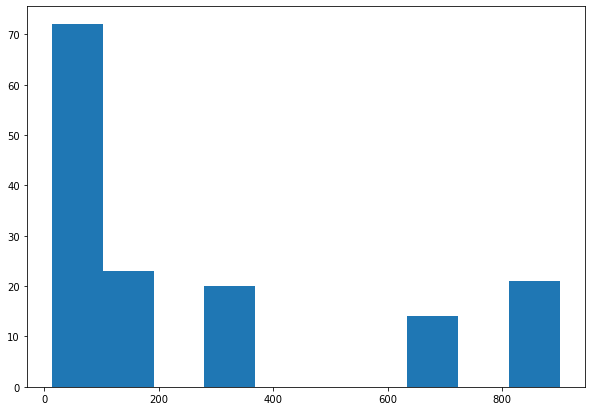

In [67]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df_y_sp50['Train_Len'])
plt.show()

In [68]:
df_y_sp50['Test_Len'].value_counts()

7     90
14    27
21    16
28    12
56     5
Name: Test_Len, dtype: int64

Again, slight edge to 60 days for training, but clearly 7 days is the winner in testing. Let's do this one more time with the Nasdaq.

In [69]:
len(nsdq)

2967

In [70]:
nsdq.head()

Symbol                                       Company Name
0   AAIT  iShares MSCI All Country Asia Information Tech...
1    AAL                      American Airlines Group, Inc.
2   AAME                      Atlantic American Corporation
3   AAOI                      Applied Optoelectronics, Inc.
4   AAON                                         AAON, Inc.

In [71]:
nsdq.loc[nsdq['Symbol']=='AFH']

Symbol                    Company Name
78    AFH  Atlas Financial Holdings, Inc.

In [72]:
nsdq = nsdq.drop(labels=[78], axis=0)

2970 stocks is WAY too many to look through, so let's just do another 50, like we did with the S&P.

I had found a few stocks were missing from my NASDAQ list, so I've written the following code to get rid of all the symbols that had been delisted since I got this data.

In [74]:
no_data=[]
for each in nsdq['Symbol']:
    stock = yf.Ticker(each)
    df1=stock.history(period='1d')
    df=df1['Close']
    if len(df)==0:
        no_data.append(each)

- AAIT: No data found for this date range, symbol may be delisted
- AAVL: No data found for this date range, symbol may be delisted
- ABAC: No data found for this date range, symbol may be delisted
- ABAX: No data found for this date range, symbol may be delisted
- ABCD: No data found for this date range, symbol may be delisted
- ABCO: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
- ABDC: No data found, symbol may be delisted
- ABGB: No data found for this date range, symbol may be delisted
- ABTL: No data found for this date range, symbol may be delisted
- ABY: No data found for this date range, symbol may be delisted
- ACAS: No data found for this date range, symbol may be delisted
- ACAT: No data found for this date range, symbol may be delisted
- ACFC: No data found for this date range, symbol may be delisted
- ACHN: No data found, symbol may be delisted
- ACPW: No data found for this date range, symbol m

- BLMT: No data found, symbol may be delisted
- BLVD: No data found for this date range, symbol may be delisted
- BLVDU: No data found for this date range, symbol may be delisted
- BLVDW: No data found, symbol may be delisted
- BNCL: No data found, symbol may be delisted
- BNCN: No data found for this date range, symbol may be delisted
- BOBE: No data found for this date range, symbol may be delisted
- BOFI: No data found for this date range, symbol may be delisted
- BONA: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BOTA: No data found for this date range, symbol may be delisted
- BPFH: No data found for this date range, symbol may be delisted
- BPFHP: No data found, symbol may be delisted
- BPFHW: No data found, symbol may be delisted
- BRCD: No data found for this date range, symbol may be delisted
- BRCM: No data found for this date range, symbol may be delisted
- BRDR: No data found, symbol may be del

- CPHR: No data found, symbol may be delisted
- CPLA: No data found for this date range, symbol may be delisted
- CPST: No data found, symbol may be delisted
- CPTA: No data found for this date range, symbol may be delisted
- CPXX: No data found for this date range, symbol may be delisted
- CRAY: No data found, symbol may be delisted
- CRDC: No data found for this date range, symbol may be delisted
- CRDS: No data found for this date range, symbol may be delisted
- CRDT: No data found for this date range, symbol may be delisted
- CRME: No data found for this date range, symbol may be delisted
- CRRC: No data found for this date range, symbol may be delisted
- CRRS: No data found for this date range, symbol may be delisted
- CRTN: No data found for this date range, symbol may be delisted
- CRWN: No data found for this date range, symbol may be delisted
- CRZO: No data found, symbol may be delisted
- CSBK: No data found for this date range, symbol may be delisted
- CSCD: No data found fo

- ESYS: No data found for this date range, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- ETRM: No data found for this date range, symbol may be delisted
- EVAL: No data found for this date range, symbol may be delisted
- EVAR: No data found for this date range, symbol may be delisted
- EVBS: No data found for this date range, symbol may be delisted
- EVEP: No data found for this date range, symbol may be delisted
- EVLV: No data found, symbol may be delisted
- EVRY: No data found for this date range, symbol may be delisted
- EXA: No data found for this date range, symbol may be delisted
- EXAC: No data found for this date range, symbol may be delisted
- EXLP: No data found for this date range, symbol may be delisted
- EXXI: No data found for this date range, symbol may be delisted
- EZCH: No data found for this date range, symbol may be delisted
- FALC: No data found for this date range, symbol may be delisted
- FBNK: No data found, symbol may be delisted
- FBR

- HDP: No data found for this date range, symbol may be delisted
- HDRA: No data found for this date range, symbol may be delisted
- HDRAR: No data found, symbol may be delisted
- HDRAU: No data found, symbol may be delisted
- HDRAW: No data found, symbol may be delisted
- HDS: No data found, symbol may be delisted
- HEOP: No data found for this date range, symbol may be delisted
- HFBC: No data found, symbol may be delisted
- HFFC: No data found for this date range, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- HILL: No data found for this date range, symbol may be delisted
- HKTV: No data found for this date range, symbol may be delisted
- HLSS: No data found for this date range, symbol may be delisted
- HMIN: No data found for this date range, symbol may be delisted
- HMNF: No data found for this date range, symbol may be delisted
- HMNY: No data found for this date range, symbol may be delisted
- HMPR: No data found for this date range, symbol may be delist

- LION: No data found, symbol may be delisted
- LIOX: No data found for this date range, symbol may be delisted
- LIQD: No data found for this date range, symbol may be delisted
- LLEX: No data found, symbol may be delisted
- LLTC: No data found for this date range, symbol may be delisted
- LMCA: No data found for this date range, symbol may be delisted
- LMCB: No data found for this date range, symbol may be delisted
- LMCK: No data found, symbol may be delisted
- LMIA: No data found for this date range, symbol may be delisted
- LMNS: No data found, symbol may be delisted
- LMOS: No data found for this date range, symbol may be delisted
- LNBB: No data found for this date range, symbol may be delisted
- LNCE: No data found for this date range, symbol may be delisted
- LNCO: No data found for this date range, symbol may be delisted
- LOCM: No data found for this date range, symbol may be delisted
- LOGM: No data found, symbol may be delisted
- LOJN: No data found for this date range, s

- NTRSP: No data found, symbol may be delisted
- NUTR: No data found for this date range, symbol may be delisted
- NVDQ: No data found for this date range, symbol may be delisted
- NVEEW: No data found for this date range, symbol may be delisted
- NVGN: No data found for this date range, symbol may be delisted
- NVSL: No data found for this date range, symbol may be delisted
- NWBO: No data found for this date range, symbol may be delisted
- NWBOW: No data found, symbol may be delisted
- NXTDW: No data found, symbol may be delisted
- NXTM: No data found, symbol may be delisted
- NYNY: No data found, symbol may be delisted
- OCLR: No data found for this date range, symbol may be delisted
- OCLS: No data found for this date range, symbol may be delisted
- OCRX: No data found for this date range, symbol may be delisted
- OGXI: No data found for this date range, symbol may be delisted
- OHAI: No data found, symbol may be delisted
- OHGI: No data found, symbol may be delisted
- OHRP: No dat

- RBPAA: No data found for this date range, symbol may be delisted
- RCPI: No data found for this date range, symbol may be delisted
- RCPT: No data found for this date range, symbol may be delisted
- RDEN: No data found for this date range, symbol may be delisted
- RECN: No data found, symbol may be delisted
- REDF: No data found for this date range, symbol may be delisted
- REIS: No data found for this date range, symbol may be delisted
- RELV: No data found for this date range, symbol may be delisted
- REMY: No data found for this date range, symbol may be delisted
- RENT: No data found for this date range, symbol may be delisted
- REXI: No data found for this date range, symbol may be delisted
- REXX: No data found for this date range, symbol may be delisted
- RGDO: No data found, symbol may be delisted
- RGDX: No data found for this date range, symbol may be delisted
- RGSE: No data found, symbol may be delisted
- RIBTW: No data found, symbol may be delisted
- RITT: No data found 

- SPU: No data found for this date range, symbol may be delisted
- SQBK: No data found, symbol may be delisted
- SQI: No data found for this date range, symbol may be delisted
- SQNM: No data found for this date range, symbol may be delisted
- SRSC: No data found, symbol may be delisted
- SSFN: No data found, symbol may be delisted
- SSH: No data found for this date range, symbol may be delisted
- SSRG: No data found for this date range, symbol may be delisted
- SSRI: No data found for this date range, symbol may be delisted
- STB: No data found, symbol may be delisted
- STBZ: No data found for this date range, symbol may be delisted
- STCK: No data found for this date range, symbol may be delisted
- STLY: No data found for this date range, symbol may be delisted
- STML: No data found, symbol may be delisted
- STNR: No data found for this date range, symbol may be delisted
- STPP: No data found for this date range, symbol may be delisted
- STRN: No data found for this date range, symbo

- VLTC: No data found, symbol may be delisted
- VLYWW: No data found, symbol may be delisted
- VNR: No data found for this date range, symbol may be delisted
- VNRAP: No data found, symbol may be delisted
- VNRBP: No data found, symbol may be delisted
- VNRCP: No data found, symbol may be delisted
- VOLC: No data found for this date range, symbol may be delisted
- VPCO: No data found for this date range, symbol may be delisted
- VRML: No data found, symbol may be delisted
- VRNG: No data found for this date range, symbol may be delisted
- VRNGW: No data found, symbol may be delisted
- VRTA: No data found for this date range, symbol may be delisted
- VRTB: No data found for this date range, symbol may be delisted
- VRTU: No data found, symbol may be delisted
- VSAR: No data found for this date range, symbol may be delisted
- VSCI: No data found for this date range, symbol may be delisted
- VSCP: No data found for this date range, symbol may be delisted
- VTAE: No data found for this dat

In [75]:
len(no_data)

1333

In [76]:
no_data[4:8]

['ABCD', 'ABCO', 'ABCW', 'ABDC']

In [77]:
y=nsdq.loc[nsdq['Symbol']==no_data[4]].index

In [78]:
y[0]

12

In [79]:
nd_index=[]
for each in no_data:
    y=nsdq.loc[nsdq['Symbol']==each].index
    nd_index.append(y[0])

In [80]:
len(nd_index)

1333

In [81]:
nsdq = nsdq.drop(labels=nd_index, axis=0)

In [82]:
nsdq.reset_index()

index Symbol                   Company Name
0         1    AAL  American Airlines Group, Inc.
1         2   AAME  Atlantic American Corporation
2         3   AAOI  Applied Optoelectronics, Inc.
3         4   AAON                     AAON, Inc.
4         5   AAPL                     Apple Inc.
...     ...    ...                            ...
1628   2955   ZION           Zions Bancorporation
1629   2958   ZIOP          ZIOPHARM Oncology Inc
1630   2960   ZIXI                Zix Corporation
1631   2963   ZNGA                     Zynga Inc.
1632   2966   ZUMZ                    Zumiez Inc.

[1633 rows x 3 columns]

Just to be safe, let's do the same thing with the S&P data.

In [83]:
no_data_sp=[]
for each in sp_500['Symbol']:
    stock = yf.Ticker(each)
    df1=stock.history(period='1d')
    df=df1['Close']
    if len(df)==0:
        no_data_sp.append(each)

- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [84]:
no_data_sp

['BRK.B', 'BF.B']

In [85]:
sp_500.loc[sp_500['Symbol']==no_data_sp[1]].index

Int64Index([78], dtype='int64')

In [86]:
sp_500.loc[sp_500['Symbol']==no_data_sp[0]].index

Int64Index([64], dtype='int64')

In [87]:
sp_500 = sp_500.drop(labels=[64,78], axis=0)

In [88]:
sp_500.reset_index(inplace=True)

In [93]:
picks=[]
for i in range (0,50):
    x = random.randint(0,len(nsdq))
    picks.append(x)

In [90]:
nsdq.reset_index(inplace=True)

In [91]:
tests=[7,14,21,28]

In [95]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=df_x.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <IBCP>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=28.499, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.395, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24.249, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24.072, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.685, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.629, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=24.854, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=26.518, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.983, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.813, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] interce

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.721, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=87.239, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.798, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=62.822, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=549.595, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=52.793, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=52.796, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=54.797, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.548 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=213.839, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=216.108, Time=0.02

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.495, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=59.492, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.621 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=219.888, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=220.978, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=221.463, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=221.081, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=221.609, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=220.508, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=220.505, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=219.822, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=220.556, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=221.779, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=220.527, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=220.705, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=221.494, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=221.256, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220.715, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=222.694, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=222.716, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=221.068, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=220.703, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=222.119, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=221.526, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=222.482, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=221.279, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.786 seconds
Performing stepwi

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1037.288, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1035.288, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1037.288, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1036.990, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1035.246, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1038.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1036.768, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1037.235, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1037.237, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1036.747, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1035.676, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1039.153, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.805 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2038.711, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2035.154, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2035.427, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2036.590, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2037.872, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2036.538, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2037.125, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2035.039, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2032.716, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2034.210, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2034.449, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2036.191, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2037.416, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2035.802, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2036.196, Time=0.06 sec
 ARIMA(3,1,1)(0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2030.753, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2032.491, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2032.770, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2034.737, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2035.736, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2034.193, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2034.465, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2033.040, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2034.753, Time=0.23 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3731.461, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3774.222, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3745.898, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3752.601, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2030.363, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2031.275, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2029.442, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2029.891, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2028.638, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2029.499, Time=0.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.031 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3729.403, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3773.201, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3744.745, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3751.459, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3772.564, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3735.523, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3735.762, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2310.111, Time=0.10 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2312.111, Time=0.18 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.557 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2885.429, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2897.655, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2885.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2886.530, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2895.668, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2888.514, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2883.436, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2887.223, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2887.150, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercep

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.510, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.697 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=71.696, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=92.783, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.778, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=78.100, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276.337, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=68.771, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=68.772, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=70.778, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.472 seconds
Performing stepwise search to minimize aic


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=361.205, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=363.150, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=365.036, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=362.142, Time=0.03 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 1.765 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=693.675, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=687.574, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=689.523, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=689.527, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=685.770, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=691.092, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.635 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2369.729, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=969.376, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=924.966, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=970.018, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=926.932, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=928.139, Time=1.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=970.588, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=942.428, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=927.515, Time=1.38 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=925.593, Time=0.27 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 7.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1036.427, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1135.433, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1099.712, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1108.344, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]        

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18.721, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.793 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45.840, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=68.933, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.945, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=54.852, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=318.609, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=42.978, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42.933, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=44.599, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=77.189, Time=0.12 s

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=252.702, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=250.947, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.830 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=622.850, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=682.818, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=656.624, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=664.811, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=682.090, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=647.272, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=648.820, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=623.720, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=650.910, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=651.771, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=649.131, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept  

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3158.121, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=3155.957, Time=0.29 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3167.492, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3156.073, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3156.343, Time=0.18 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3152.708, Time=0.53 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=1.75 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=2.14 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=inf, Time=1.73 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=3150.245, Time=0.71 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=3154.550, Time=0.24 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=3154.781, Time=0.84 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=3154.790, Time=0.30 sec
 ARIMA(5,2,3)(0,0,0)[0]            

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-161.756, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-166.499, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-165.481, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-163.698, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-164.764, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-164.582, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-163.956, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-168.444, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-166.715, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-166.529, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-167.434, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-165.916, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] int

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-480.584, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-478.094, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-479.999, Time=0.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-479.003, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-480.062, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-482.118, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-479.740, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-479.141, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-478.426, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-481.040, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-478.823, Time=0.83 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-483.948, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-480.022, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-481.653, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-481.036, Time=0.20 sec
 ARIMA(4,1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=473.686, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10.247, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.765, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4.396, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8.349, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=123.709, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.108, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6.244, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4.166, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1.524, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6.070, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7.050, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12.275, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2.254, Time=

 ARIMA(3,2,0)(0,0,0)[0]             : AIC=532.802, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=479.885, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=471.706, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=400.803, Time=0.28 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=400.516, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=411.751, Time=0.22 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=397.108, Time=0.25 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=398.800, Time=0.39 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=398.680, Time=0.36 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=399.830, Time=0.67 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec

Best model:  ARIMA(4,2,2)(0,0,0)[0]          
Total fit time: 4.996 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=470.2

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=54.096, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=56.806, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.447 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.616, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.673, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=151.361, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=156.471, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=282.108, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=284.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=282.538, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=282.433, 

 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2655.477, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2606.912, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2585.213, Time=0.09 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2587.208, Time=0.17 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.753 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2972.109, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2968.988, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2969.444, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2969.452, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2969.729, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2971.398, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.085 seconds
Performing stepwise s

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=726.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=727.124, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=726.779, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=728.416, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=728.179, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.724 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1627.877, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1521.948, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1492.688, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1479.715, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1452.727, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.632, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.504, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-27.300, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.800, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.178, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.376 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-35.791, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.811, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.884, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-35.910, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.522, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-37.198, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
Performing stepwise search 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-39.423, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.089, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-40.820, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-72.393, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77.806, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-75.834, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-75.837, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-79.789, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.660, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.583 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-283.264, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-281.3

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=61.511, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73.121, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.824, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.473, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.733, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.876 seconds
Performing 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=811.979, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=815.853, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=811.344, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=810.267, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=812.122, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=811.970, Time=0.60 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=811.941, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=813.320, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=808.910, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=810.837, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=809.301, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=810.646, Time=0.39 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=810.628, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=810.586, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0]      

 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=60.649, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=60.903, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.001, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=62.589, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.908 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.589, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.518, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=136.537, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133.756, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=138.338, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.217 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4394.293, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4396.415, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.224, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.722, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.244, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.590, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=59.256, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59.211, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61.138, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.509, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.273 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3616.427, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.004 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4389.230, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4388.762, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4388.939, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4387.715, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4390.150, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.444 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
117  yfinance.Ticker object <TNXP>       720        7 -0.086904  0.042876   

         RMSE        R2  
117  0.052185 -0.115701  
Processing:  yfinance.Ticker object <CGNX>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=93.917, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=137.490, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=90.723, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=116.979, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=348.265, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=91.848, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=92.222, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=94.538, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.560 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=214.611, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=209.154, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=210.611, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=210.713, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1413.209, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.804, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1410.254, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1411.107, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1414.396, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1410.633, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1410.257, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1411.967, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1409.028, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1409.310, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1408.983, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1409.887, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1410.653, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1410.452, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1410.403, Time=0.02 sec
 ARIMA(2,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1409.327, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1409.115, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1409.067, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1407.976, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1410.875, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.220 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2572.616, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2595.662, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2590.512, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2591.200, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2594.420, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2591.580, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2593.791, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2593.842, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=140.669, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=140.396, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=141.304, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=141.490, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=138.474, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=142.637, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.203 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=465.472, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=467.461, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=467.461, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=464.027, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.973 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=463.151, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=465.149, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=465.150, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=461.589, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=467.114, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.640 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=774.252, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=775.698, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=775.774, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=772.309, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=776.866, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.920 seconds
Performing stepwise search to m

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.322, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.321, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33.633, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=49.134, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=91.197, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.060, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64.407, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=519.441, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.488, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49.645, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=50.934, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total 

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.212, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25.925, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.749 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=34.544, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.291, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.991, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=35.972, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=260.342, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=34.462, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.764, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=35.720, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.609 seconds
Performing stepwise search to minimize a

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3294.886, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3296.681, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3296.688, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3293.924, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3298.558, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.502 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.946, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.169, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.347, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1485.631, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.540 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3108.947, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2883.367, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2811.184, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2775.270, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2728.746, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2717.608, Time=0.09 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2719.606, Time=0.16 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.453 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-408.271, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-410.852, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-409.523, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-409.485, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-405.920, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-407.666, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.569 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-584.455, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-300.759, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-466.524, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-581.035, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-585.732, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-584.467, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-585.753, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-411.787, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-414.809, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-413.375, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-413.357, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-407.899, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-411.441, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.616 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-586.545, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-304.607, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-469.812, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-584.249, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-588.518, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-587.261, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-58

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-406.005, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-409.003, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-407.301, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-407.285, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-403.587, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-405.412, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-582.637, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-301.092, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-465.096, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-580.003, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : A

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-581.944, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-299.750, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-464.703, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-579.235, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-583.341, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-582.056, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-583.243, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-579.954, Time=0.29 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-585.286, Time=0.12 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-583.290, Time=0.24 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-585.257, Time=0.43 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 2.398 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1523.822, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] in

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1277.635, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1315.258, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1277.727, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1278.636, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1280.756, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1267.975, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1279.397, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1263.500, Time=0.46 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1263.279, Time=0.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1262.506, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1262.380, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1279.429, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1271.786, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1263.779, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1280.879, Time=0.11 sec
 ARIMA(5,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1276.599, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1314.378, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1276.692, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1277.609, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1279.787, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1266.788, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1278.354, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1262.330, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1262.143, Time=0.69 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1261.382, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1261.334, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1278.444, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1270.742, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1262.720, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1279.898, Time=0.10 sec
 ARIMA(5,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1282.128, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1283.136, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1285.367, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1272.789, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1283.883, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1268.256, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1268.001, Time=0.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1267.183, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1267.133, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1284.010, Time=0.38 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1276.520, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1268.496, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1285.453, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1272.584, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1271.133, Time=0.69 sec
 ARIMA(4,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1286.620, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1324.335, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1286.670, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1287.658, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1289.748, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1276.982, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1288.301, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1272.680, Time=0.58 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1272.585, Time=0.66 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1271.854, Time=0.63 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1271.585, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1288.483, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1280.662, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1273.050, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1289.925, Time=0.09 sec
 ARIMA(5,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1298.696, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.553 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1534.764, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1534.725, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1531.560, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1531.990, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1532.868, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1531.986, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1532.084, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1532.882, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1529.725, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1530.139, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1530.242, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1530.155, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46.626, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.522, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.978, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.574, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42.882, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=43.237, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=41.427, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=43.007, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=42.618, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39.429, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.526, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41.238, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=41.008, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.575, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=40.618, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]    

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1309.302, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1310.302, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1305.828, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1306.408, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1308.326, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1306.439, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1306.435, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1307.417, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1303.856, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1304.465, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1304.462, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1304.437, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1305.440, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.466 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1901.598, Time=0.98 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1899.063, Time=0.33 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1893.744, Time=1.13 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=1.07 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1899.273, Time=1.51 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=1899.642, Time=0.45 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=1897.604, Time=0.47 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1897.610, Time=0.51 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=1898.381, Time=1.34 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 22.338 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2245.627, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2363.813, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2310.469, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2316.208, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1936.560, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1930.122, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1875.045, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1870.555, Time=0.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1877.046, Time=0.66 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1872.555, Time=1.01 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1872.555, Time=2.19 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1870.807, Time=0.99 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1874.553, Time=0.67 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1871.264, Time=0.43 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 13.018 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2222.201, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2346.462, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] in

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1930.398, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1875.308, Time=0.48 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1870.872, Time=0.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1877.321, Time=0.68 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1872.865, Time=0.88 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1871.079, Time=1.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1874.862, Time=0.92 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1871.012, Time=0.46 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 13.538 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2221.520, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2344.766, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2289.906, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] interce

 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=1873.276, Time=1.69 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1869.436, Time=0.53 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1876.295, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1873.906, Time=0.35 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1871.051, Time=1.17 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=1871.088, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1883.039, Time=0.40 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1871.950, Time=0.45 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1869.056, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1874.948, Time=0.38 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1871.051, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1923.378, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1875.522, Time=0.31 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1872.779, Time=1.06 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 21.320 second

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1383.995, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1391.990, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1385.986, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1385.984, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1390.595, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1387.877, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1381.997, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1393.824, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1389.993, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1383.988, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1383.986, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1395.783, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1394.931, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1388.597, Time=0.04 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1385.881, Time=0.14 sec

Best mode

 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=595.826, Time=0.26 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=594.236, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=593.409, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=598.618, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=593.722, Time=0.06 sec

Best model:  ARIMA(0,1,5)(0,0,0)[0] intercept
Total fit time: 2.199 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1398.630, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1409.531, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1398.654, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1400.042, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1407.531, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1398.798, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1399.268, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1391.998, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] int

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 1.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=611.869, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=619.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=620.946, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=620.847, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=618.726, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=618.898, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=618.273, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=605.011, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=609.005, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=602.593, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=606.953, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=612.323, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=618.071, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=619.704, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=619.650, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=616.866, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=619.698, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=619.220, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=606.040, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=610.179, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=604.435, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=609.051, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=606.329, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=604.821, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=604.683, Time=0.09 sec
 ARIMA(5,1,3)(0,0,0)[0] inter

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=99.776, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=101.515, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.488 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=224.146, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=224.145, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225.674, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.272, Time=0.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=222.694, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=222.994, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=692.975, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=694.975, Tim

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=683.421, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=685.409, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=685.408, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=682.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=687.229, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.368 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1296.930, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1298.829, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1298.833, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1296.006, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1299.894, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit tim

 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1.249, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=0.874, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-2.980, Time=0.23 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=4.191, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 2.871 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1.272, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.031, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.952, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.494, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.411, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.227 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5.673, Time=0.33 sec
 A

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2.249, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.439, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.519, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-0.272, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.268, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1.725, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3.762, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1.764, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.764, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2.863, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=0.096, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.540 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.107, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.624, Tim

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-40.128, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-72.153, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=134.473, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-72.365, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-70.445, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-70.487, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-72.167, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.056 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-148.232, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-66.142, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-150.318

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76.653, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=71.285, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=68.116, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=79.510, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=69.963, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=70.027, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=75.551, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=69.921, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-17.503, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.226, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.762, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.662, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.133, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-30.332, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-36.893, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.234, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-35.674, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-36.412, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-34.761, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-56.522, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-76.907, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-68.075, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=132.602, T

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=729.486, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=731.375, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=731.382, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=728.552, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=732.851, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.588 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1618.339, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1617.112, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1618.704, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1618.763, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1617.117, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1619.806, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.470 seconds
Performing stepwise s

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=154.783, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=156.671, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.760 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=739.680, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=741.272, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=741.307, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=738.656, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.493 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1633.315, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1632.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1634.467, Tim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=356.286, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=351.028, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=353.056, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=351.745, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=352.971, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=347.222, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=350.280, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=354.289, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=348.785, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=349.028, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=353.704, Time=0.01 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=351.056, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=349.747, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=350.971, Time=0.06 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 0.771 seconds
Performing st

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1124.840, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1121.002, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1121.003, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1125.496, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1125.749, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1126.279, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1122.938, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1117.347, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1124.919, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1123.371, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1119.347, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1119.347, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1123.753, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1124.162, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1124.622, Time=0.07 sec
 ARIMA(3,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2130.269, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2130.382, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2125.090, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2125.112, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2128.559, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2128.639, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2128.893, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2127.383, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2122.382, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2129.100, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2129.224, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2124.034, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2124.055, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2127.427, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2128.720, Time=0.11 sec
 ARIMA(3,1

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2121.090, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2121.337, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2120.871, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2115.907, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2122.132, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2122.262, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2117.801, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2117.807, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2120.410, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2121.842, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2122.164, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2119.676, Time=0.67 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.835 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3828.895, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2545.606, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2509.826, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2441.406, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2443.406, Time=0.17 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.702 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5203.927, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4924.362, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4826.423, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=4751.046, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4668.629, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.835, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-60.647, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.572 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-66.429, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-67.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-68.856, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-68.228, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-67.156, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-65.776, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-70.371, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-68.474, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-68.5

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-398.169, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-398.345, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-396.853, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-396.735, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-399.650, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-396.522, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-397.232, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-407.165, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-399.960, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-400.136, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-398.642, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-398.525, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-401.444, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-398.309, Time=0.33 sec
 ARIMA(3,1,1)(0

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18.161, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18.808, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.985, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=20.253, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20.357, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22.149, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.640 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43.919, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.529, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.375, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41.924, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27.309, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23.470, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20.503, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22.224, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=142.482, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=21.972, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22.086, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23.944, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.620 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=41.230, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50.359, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.000, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.372, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=303.127,

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-488.310, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-478.750, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-477.181, Time=1.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-477.367, Time=0.59 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-476.826, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-485.277, Time=1.26 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-489.011, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-488.751, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-479.134, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-487.728, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-481.134, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-477.684, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-477.255, Time=0.12 sec
 ARIMA(4,1,3)(0,0,0)

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-480.066, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-480.068, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-478.488, Time=1.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-490.623, Time=0.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.081 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-743.749, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-900.479, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-994.014, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-1049.590, Time=0.27 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-1066.704, Time=0.13 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-1077.124, Time=0.23 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(4,2,1)(0,0,0)[0]           

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-1637.752, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1625.593, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-1622.572, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1622.386, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1635.817, Time=1.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.868 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12.162, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.649, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10.745, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10.867, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10.092, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.306 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2090.209, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2090.835, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2088.313, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2071.961, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2090.781, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2087.764, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2077.804, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2073.203, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2068.516, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2088.260, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2088.886, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2086.364, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2070.012, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2088.840, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2085.811, Time=0.25 sec
 ARIMA(3,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3839.867, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3840.657, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3832.735, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3806.781, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3840.395, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3834.479, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3838.015, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3804.448, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3838.479, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3839.279, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3805.490, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3805.402, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3839.083, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3833.048, Time=0.29 sec
 ARIMA(3,1,1)(0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4684.996, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4657.812, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4658.422, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4618.717, Time=0.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4618.693, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4657.980, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4658.556, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4655.058, Time=0.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4617.470, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4616.280, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4656.948, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4657.571, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4617.879, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4651.452, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4657.236, Time=0.05 sec
 ARIMA(1,1

Processing:  yfinance.Ticker object <FOX>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15.970, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8.271, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10.230, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.231, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.927, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12.240, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.360 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.877, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.695, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32.314, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.013, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1254.003, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1256.003, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1256.003, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1252.014, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1257.960, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.715 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1254.003, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1256.003, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1256.003, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1252.014, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1257.960, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.677 seconds
Performing stepwise s

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1232.203, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1234.200, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1234.200, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1230.216, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1236.187, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.208 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
395  yfinance.Ticker object <CUBA>       180        7 -0.100418  0.02587   

         RMSE        R2  
395  0.038443 -0.100516  
Processing:  yfinance.Ticker object <SBNY>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=90.159, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=91.735, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74.885, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=75.927, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=76.296, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=196.009, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=80.796, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.604 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=178.381, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=191.855, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=173.842, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=180.405, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=417.574, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=175.926, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=175.791, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1067.821, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1067.291, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1069.049, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1069.009, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1071.670, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1070.823, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.374 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2099.886, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2371.101, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2238.978, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2100.381, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2100.714, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=2100.025, Time=0.25 sec
 ARIMA(2,2,3)(0,0,0)[0]    

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3815.259, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3810.748, Time=0.56 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3817.259, Time=0.18 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=3809.412, Time=0.57 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=3818.253, Time=0.25 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=3808.534, Time=0.52 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=3809.347, Time=0.68 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=3808.463, Time=0.51 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3808.357, Time=0.36 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=3806.718, Time=0.44 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3813.042, Time=0.24 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=3808.285, Time=0.44 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=3812.478, Time=0.33 sec
 ARIMA(3,2,4)(0,0,0)

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2243.780, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2241.791, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2247.774, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2245.779, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2245.779, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2244.515, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2243.789, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.533 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-42.640, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.462, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45.759, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-47.073, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47.575, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45.090, Time=0.09 sec

Best model:  ARIMA(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-341.880, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-334.388, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-334.847, Time=0.11 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.509 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-633.954, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-624.011, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-639.308, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-639.903, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-626.006, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-637.916, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-637.915, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   :

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1702.204, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1663.698, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1700.228, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1700.231, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1698.247, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1704.166, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1702.191, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1702.194, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1702.450, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1700.210, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2221.566, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2168.014, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2224.309, Time=0.07 sec
 ARIMA(0,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=202.422, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=203.562, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.596 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=598.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=600.015, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=600.021, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=597.443, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.621 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1154.185, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1146.580, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1148.196, Tim

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=218.922, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=294.190, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=216.902, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=252.937, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=638.068, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=218.902, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=218.902, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=220.820, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.636 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=592.141, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=594.051, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=594.059, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1086.051, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1093.494, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1092.252, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1087.530, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1087.916, Time=0.19 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.392 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1959.491, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2009.414, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1960.329, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1963.737, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2007.418, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1962.489, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1962.776, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1957.760, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1955.625, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1955.780, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1951.031, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1949.411, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1950.539, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1940.287, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1946.938, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1942.103, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1941.762, Time=0.59 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1946.419, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1944.233, Time=0.71 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1938.320, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1947.445, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1944.972, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1940.135, Time=0.27 sec
 ARIMA(4,1

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1941.309, Time=0.45 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.985 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2315.486, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2371.117, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2316.676, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2320.406, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2369.267, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2318.592, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2318.862, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2314.059, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2312.243, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2313.049, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2301.479, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2310.178, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2310.072, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2310.892, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2299.096, Time=0.50 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2307.981, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2300.738, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2300.151, Time=0.76 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2307.004, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2303.032, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2297.258, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2308.245, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2306.150, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2298.892, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2298.299, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2309.034, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2310.031, Time=0.25 sec
 ARIMA(5,1

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35.434, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-39.062, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-37.706, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-39.074, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-38.660, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-32.024, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.417 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.103, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.510, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.678, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.923, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-28.538, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-61.117, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.156, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.721, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.955, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.190, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-61.532, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-61.039, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-60.804, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-63.453, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-61.594, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-61.476, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : A

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21.035, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22.697, Time=0.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=22.829, Time=0.46 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=26.513, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=15.557, Time=0.81 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=14.165, Time=0.65 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=24.416, Time=0.38 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=18.900, Time=1.11 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=12.441, Time=0.40 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=22.712, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=13.887, Time=0.48 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=17.165, Time=0.58 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=21.141, Time=0.32 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=14.522, Time=0.71 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0]       

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=46.225, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.427, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.823, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.241, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=134.710, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=43.308, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.488, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.835 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.043, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=80.113, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.332, Time=0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1167.371, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1162.010, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1164.004, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1164.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1162.154, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1166.005, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1850.447, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1854.243, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1844.476, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1844.751, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1853.123, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1846.463, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1846.461, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0

Processing:  yfinance.Ticker object <CONN>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38.444, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.459, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.769, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.160, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=114.361, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.831, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.446, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=108.428, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=106.589, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=110.413, Time=0.03 sec

Best model:  ARIMA(0,1,0)

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2311.010, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2307.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2312.693, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.290 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.457, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57.781, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=57.659, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.596, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59.691, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.201 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=110.237, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=104.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.635, 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1646.212, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1647.510, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1644.116, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1644.452, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1646.120, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1645.555, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1645.785, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1646.911, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1642.838, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1644.234, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1644.488, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1643.176, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1644.733, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.108 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-999.534, Time=1.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1011.786, Time=1.54 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1008.962, Time=0.48 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-1016.814, Time=1.90 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1015.714, Time=1.45 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-1017.818, Time=2.41 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-1015.541, Time=2.76 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=-1014.579, Time=2.51 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=-1016.672, Time=1.84 sec

Best model:  ARIMA(5,1,4)(0,0,0)[0] intercept
Total fit time: 23.037 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1383.438, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1374.268, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1372.729, Time=0.10 sec
 ARIMA(0,1,1)(0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1380.346, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1384.873, Time=0.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1383.526, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1383.561, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1384.445, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1384.239, Time=0.25 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 5.730 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.056, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.140, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22.484, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23.468, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.160, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.466 seconds
Performing step

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-52.000, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.563, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57.586, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.585, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.427, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55.563, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.424 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-104.479, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.386, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.773, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-107.713, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.102, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.962, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.396 seconds
Performing stepwi

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1132.651, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1134.125, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1135.472, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1135.482, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1133.311, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1136.911, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1137.665, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1133.072, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1133.431, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1137.471, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1135.146, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1135.295, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.537 seconds
Performin

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=218.225, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=217.880, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.677 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=607.259, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=608.046, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=610.046, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=610.046, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=609.352, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=611.651, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=611.491, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=606.518, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=608.839, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=606.548, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1073.682, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1075.012, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1065.417, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1069.441, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1064.018, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1068.739, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1065.683, Time=0.46 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1065.649, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1064.518, Time=1.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1068.678, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1067.643, Time=0.71 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1064.272, Time=0.16 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0] intercept
Total fit time: 5.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1736.880, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2405.083, Time=0.23 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=2402.677, Time=0.29 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 7.570 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2918.066, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2917.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2918.853, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2918.864, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2915.526, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2920.833, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.223 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=58.373, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.858, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.021, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AI

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2918.611, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.277 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.210, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50.177, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.784, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.336 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.521, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.520, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113.520, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.082, Time=0.01 se

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-696.048, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-669.151, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-715.228, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-717.219, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-715.224, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-712.576, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-713.221, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-719.140, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-698.002, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-717.151, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-717.146, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-714.480, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-715.141, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.228 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=0.276, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.668 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.489, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23.222, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.258, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.498 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.873, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.554, Time=0.02 sec
 A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-0.026, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.025, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-0.026, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.597, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1.948, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.533, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1.518, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1.533, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1.533, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.079, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=0.451, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.234 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-198.561, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-177.467, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-185.

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-597.093, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-589.153, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-595.452, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-595.662, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-593.849, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-597.355, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-595.646, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-595.830, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-596.588, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-594.026, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.600 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-609.241, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-609.206, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-613.346, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-30.228, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.162, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-23.786, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1.185, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.036, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-30.872, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-18.973, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-22.751, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-29.496, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-22.471, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-24.286, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-28.347, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24.828, Time=0.09 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 0.860 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-597.556, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-600.586, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-599.135, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-599.495, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-599.880, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-597.653, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.080 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-501.386, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-492.586, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-498.673, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-499.039, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-493.891, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-496.119, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-496.675, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-16.911, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16.707, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-14.864, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.688 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.667, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.688, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.019, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16.664, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.355 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=53.035, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.566, Time=0.0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.526, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28.823, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29.664, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31.932, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.845, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=30.529, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=30.235, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=17.615, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=27.089, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=27.946, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=30.168, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=25.115, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=28.764,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=44.177, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=42.478, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=44.018, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45.723, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43.195, Time=0.02 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.692 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=247.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=243.910, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241.544, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=247.712, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=239.517, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=238.662, T

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=56.192, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=55.019, Time=0.02 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.717 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=255.168, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=251.199, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248.822, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=255.162, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=241.303, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=246.601, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=250.290, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=249.394, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
To

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=84.295, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=77.072, Time=0.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=79.563, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=75.669, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=75.548, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=82.360, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=75.600, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=77.539, Time=0.06 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.167 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=261.687, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=259.671, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=258.195, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=261.369, 

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=257.027, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=252.651, Time=0.51 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=259.026, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=259.400, Time=0.08 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=262.157, Time=0.11 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0] intercept
Total fit time: 4.474 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=760.453, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=804.661, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=761.172, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=764.486, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=802.661, 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-201.296, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.602 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-338.663, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-344.719, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-342.731, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-342.733, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-346.590, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-340.719, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.371 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-904.416, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-911.371, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-910.029, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-910.060, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]           

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-194.384, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.577 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-337.836, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-343.981, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-342.065, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-342.078, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-345.950, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-340.512, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.556 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-904.391, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-911.559, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-910.112, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-910.134, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]           

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=754.703, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=775.544, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=777.162, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=777.262, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=773.585, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=765.206, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=768.143, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=756.703, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=774.627, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=754.349, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=760.936, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=767.673, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=762.388, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=766.536, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=761.217, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=751.391, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=757.749, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=762.044, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=764.577, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=759.249, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=751.672, Time=0.14 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.61 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 5.320 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1067.012, Tim

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=763.595, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=766.506, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=754.850, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=772.844, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=753.008, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=750.324, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=764.796, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=752.086, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=766.126, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=764.572, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=748.352, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=764.533, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=762.821, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]          

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=749.066, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=751.976, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=763.534, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=749.976, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=761.858, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 5.019 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1063.939, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1100.257, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1101.432, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1101.627, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1099.009, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1080.704, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1084.834, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=444.314, Time=0.13 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=446.835, Time=0.16 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.843 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=591.756, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=621.136, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=613.860, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=616.176, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=619.164, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=594.706, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=598.617, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=583.275, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=596.239, Time=0.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=583.404, Time=1.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=585.179, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=581.997, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=614.017, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=606.443, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=608.903, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=612.062, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=585.131, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=589.465, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=573.598, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=586.668, Time=0.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=573.395, Time=0.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=572.725, Time=0.42 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=582.333, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=574.705, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=589.463, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=581.096, Time=0.21 sec
 ARIMA(5,1,2)(0,0,0)[0] i

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=584.750, Time=0.38 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=583.804, Time=1.90 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=580.846, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=591.423, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=588.689, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=582.845, Time=0.54 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=582.839, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=592.966, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=582.796, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=581.217, Time=0.34 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=581.879, Time=0.77 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 12.623 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=633.261, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=666.084, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=638.877, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=642.941, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=625.092, Time=0.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=639.678, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=624.176, Time=1.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=623.426, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=635.706, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=625.333, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=642.837, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=634.246, Time=0.23 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=625.414, Time=2.38 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=621.587, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=637.943, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=633.886, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=623.498, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=60.436, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.566, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.292, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.530, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.081, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=57.328, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.162 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=125.961, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=204.427, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=125.304, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=162.211, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=634.199, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=127.284, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=127.289, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=904.511, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.873 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1540.843, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1545.981, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1539.051, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1538.932, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1544.565, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1538.545, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1540.032, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1540.182, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1540.801, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1541.049, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1539.787, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.710 seconds
Performing s

Processing:  yfinance.Ticker object <RUSHA>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.144, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.144, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.397, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.123, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.275 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.212, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.751, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=83.538, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.043, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1859.143, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.078 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.845, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40.666, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40.610, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.707, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42.601, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.251 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.829, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.523, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.528, Time=0.02 

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1492.409, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1498.100, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1499.167, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1500.336, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1494.385, Time=0.58 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.048 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1858.502, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1852.738, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1852.904, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1852.987, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1851.152, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1854.563, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.312 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
3

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.134, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.345, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-32.323, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.108, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31.131, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.430 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22.195, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.880, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25.565, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25.488, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27.694, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23.725, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.541 seconds
Performing stepwise search 

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-444.192, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-651.290, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-643.320, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-644.477, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-643.904, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-644.867, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-652.313, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-652.516, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-650.739, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-651.720, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-650.965, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-654.107, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-645.403, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38.991, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.709, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.701, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.695, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.127, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.024, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.672, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.527, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.843, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76.026, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75.545, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=346.686, Time=0.28 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=342.104, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=344.620, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=330.975, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=443.492, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=329.439, Time=0.16 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=402.577, Time=0.05 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=330.585, Time=0.20 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=324.662, Time=0.24 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=326.659, Time=0.64 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=326.656, Time=0.63 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=334.710, Time=0.73 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=328.661, Time=0.51 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=586.883, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=591.165, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=591.229, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=587.543, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=587.744, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=591.583, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=592.218, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=588.200, Time=0.40 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.786 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.767, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20.424, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20.599, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=119.388, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
1400/50

28.0

In [97]:
a=0
b=len(stock_res_nd50)
while a<=(b-28):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+28)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=28

In [98]:
stock_res_nd50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     1400 non-null   object 
 1   Train_Len  1400 non-null   object 
 2   Test_Len   1400 non-null   object 
 3   Exp_var    1400 non-null   float64
 4   MAE        1400 non-null   float64
 5   RMSE       1400 non-null   float64
 6   R2         1400 non-null   float64
dtypes: float64(4), object(3)
memory usage: 127.5+ KB


In [99]:
df_y_nd50['Test_Len'].value_counts()

7     96
14    22
28    18
21    14
Name: Test_Len, dtype: int64

In [100]:
df_y_nd50['Train_Len'].value_counts()

360    25
900    23
30     23
720    22
60     21
14     20
180    16
Name: Train_Len, dtype: int64

Still no clear winner in the training length. But test length is definitely going to be 7 days. What if there is some correlation between the test length and training length? Let's run through these indices again, but this time with just 7 days as our test length.

In [101]:
tests=[7]

In [102]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_d30.columns)
df_y_d30=df_x.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.365, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.943, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58.814, Time=0.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.546, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.290 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.322, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.054, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115.032, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.324, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=117.022, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4054.602, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4084.448, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4080.031, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4080.633, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4083.727, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4081.185, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4081.358, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4077.920, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4080.030, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4074.403, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4080.403, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4054.034, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4080.553, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.046, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106.259, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=106.250, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=107.721, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=104.842, Time=0.00 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.199 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=243.229, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=329.944, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=242.351, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=293.462, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=755.468, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=243.081, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=243.398, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=241.357, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1931.431, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1933.118, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1932.063, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1933.925, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1934.280, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1923.125, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1918.863, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1931.115, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1932.574, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1931.698, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1933.544, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]       

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1680.562, Time=0.20 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1672.823, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1666.833, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1687.056, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1668.861, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1667.466, Time=0.45 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1668.177, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1686.222, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1678.566, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1667.326, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1670.826, Time=0.16 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.532 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3036.396, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3075.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1767.581, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1764.759, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1768.722, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1768.742, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1772.695, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1751.902, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1765.124, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1765.135, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1763.152, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1767.092, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1767.132, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1771.088, Time=0.16 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.396 seconds
Performin

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1965.126, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1965.257, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1965.483, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1963.504, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1966.520, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.668 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3543.516, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3573.168, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3571.927, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3572.293, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3572.222, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3560.047, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3573.150, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2399.134, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2442.252, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2403.651, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2411.051, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2440.361, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2397.918, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2396.498, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2397.616, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2403.517, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2393.086, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2394.886, Time=0.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2394.951, Time=0.52 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2398.972, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2391.210, Time=0.22 sec
 ARIMA(0,1,3)(0

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3169.419, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3197.405, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3197.637, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3170.935, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3170.936, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3197.007, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3199.197, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3199.636, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.45 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.779 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3902.141, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3933.796, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3928.010, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2966.480, Time=0.40 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.247 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3650.834, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3660.689, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3651.232, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3652.304, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3659.149, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3652.704, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3653.186, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3648.436, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3652.826, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3636.810, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3635.944, Time=0.53 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3644.566, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3853.139, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3888.400, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3884.020, Time=0.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3853.042, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3870.211, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3855.028, Time=1.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3857.282, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3856.954, Time=1.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3852.159, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3869.168, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3879.312, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3883.175, Time=0.37 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3854.136, Time=1.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3883.306, Time=0.13 sec
 ARIMA(1,1,4)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4372.371, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4327.518, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4339.813, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4327.523, Time=0.90 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4340.576, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4345.707, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4326.657, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4368.020, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4338.814, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4341.402, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4328.006, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4371.380, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4326.660, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2538.463, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2541.095, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2531.522, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2537.623, Time=0.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2487.593, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2539.894, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2540.719, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2489.389, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2539.318, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2540.387, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2530.577, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2538.508, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.83 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.391 seconds
         

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1626.030, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1619.231, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1621.024, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1621.038, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1617.723, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1622.670, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2915.017, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2915.614, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2915.729, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2914.331, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2916.809, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=168.716, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=166.628, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=170.705, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.227 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=349.357, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=447.433, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=343.474, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=399.528, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=831.060, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=345.431, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=345.406, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=347.383, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.443 seconds
Performing stepwise search 

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=927.005, Time=0.19 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=917.185, Time=0.85 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=917.214, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=932.295, Time=0.04 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=926.170, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=917.118, Time=0.16 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=918.392, Time=0.22 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 5.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1555.557, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1568.640, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1566.850, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1567.340, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1567.066, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1565.013, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] inter

 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4236.093, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4230.439, Time=0.61 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4232.248, Time=0.83 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=4232.365, Time=0.72 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4237.878, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4237.611, Time=0.47 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=4233.198, Time=0.74 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=4229.964, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=4235.633, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4235.682, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4231.739, Time=0.55 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=4231.869, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4233.730, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=4237.379, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4237.197, Time=0.27 sec
 ARIMA(2,1

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4903.628, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4911.919, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4904.921, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4901.977, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4918.997, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4903.605, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4903.442, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4912.159, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4904.903, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.552 seconds
                           Symbol Train_Len Test_Len   Exp_var     MAE  \
45  yfinance.Ticker object <CSCO>       180        7  0.564631  0.1715   

        RMSE        R2  
45  0.219431  0.563098  
Processing:  yfinance.Ticker object <PG>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=125.190, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.116 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=254.343, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=329.725, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=249.265, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=284.153, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=777.297, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=251.143, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=250.998, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=251.883, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.751 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=796.852, Ti

 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=112.028, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=113.815, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 1.869 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.323, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=242.496, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.580, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=239.547, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=244.365, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=954.084, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=949.548, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=948.631, Ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2408.528, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2411.655, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2387.752, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2406.655, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2389.441, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2393.879, Time=0.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2386.387, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2388.723, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2406.211, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2388.119, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2391.800, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2410.264, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]  

 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=784.578, Time=1.02 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=787.638, Time=0.39 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=779.590, Time=0.47 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=782.595, Time=0.58 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=inf, Time=1.33 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=785.649, Time=0.27 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=781.089, Time=0.96 sec

Best model:  ARIMA(4,1,5)(0,0,0)[0]          
Total fit time: 14.772 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1445.478, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1430.184, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1430.986, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1443.736, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3738.580, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3721.194, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3760.473, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3761.439, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3756.207, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3722.670, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3760.555, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3746.207, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3738.002, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3722.264, Time=0.51 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.119 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.190, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4580.887, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=668.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=668.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=668.782, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=666.258, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=670.680, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.517 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1567.173, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1574.315, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1563.142, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1564.222, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1572.650, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1564.896, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1564.965, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
stock_res_d30.head(14)

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE         R2
0     MMM        14        7 -2.159508e+00  7.358687  7.963700 -20.615146
1     MMM        30        7  1.110223e-16  4.137148  4.477731  -5.833518
2     MMM        60        7  1.110223e-16  4.137148  4.477731  -5.833518
3     MMM       180        7 -4.429925e-02  3.783103  4.168444  -4.922108
4     MMM       360        7  1.110223e-16  4.137148  4.477731  -5.833518
5     MMM       720        7  1.110223e-16  4.137148  4.477731  -5.833518
6     MMM       900        7  1.110223e-16  4.137148  4.477731  -5.833518
7     AXP        14        7  2.220446e-16  2.764597  3.501076  -1.507780
8     AXP        30        7  0.000000e+00  2.132510  2.452003  -0.230065
9     AXP        60        7  1.780954e-01  3.094687  3.501112  -1.507832
10    AXP       180        7  1.701793e-01  2.778236  3.233580  -1.139211
11    AXP       360        7  0.000000e+00  2.132510  2.452003  -0.230065
12    AXP       720        7 -1.975758e-02  2.163850  2.494778  -0.273357
13    AXP       900        7 -7.180020e-02  2.145047  2.425449  -0.203568

In [104]:
len(stock_res_d30)

210

In [105]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [106]:
a=0
b=len(stock_res_d30)
while a<=(b-7):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+7)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_d30=pd.concat([df_y_d30,df_ph])
    a+=7

In [107]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
3      MMM       180        7 -4.429925e-02  3.783103  4.168444 -4.922108
1      MMM        30        7  1.110223e-16  4.137148  4.477731 -5.833518
2      MMM        60        7  1.110223e-16  4.137148  4.477731 -5.833518
8      AXP        30        7  0.000000e+00  2.132510  2.452003 -0.230065
11     AXP       360        7  0.000000e+00  2.132510  2.452003 -0.230065
..     ...       ...      ...           ...       ...       ...       ...
200    WBA       360        7  0.000000e+00  1.787143  2.579725 -0.616153
201    WBA       720        7  0.000000e+00  1.787143  2.579725 -0.616153
205    WMT        60        7  3.070653e-01  1.279830  1.474507 -0.526424
203    WMT        14        7  0.000000e+00  2.278571  2.572205 -3.645079
204    WMT        30        7  0.000000e+00  2.278571  2.572205 -3.645079

[90 rows x 7 columns]

In [108]:
df_y_d30['Train_Len'].value_counts()

30     18
180    18
60     15
900    11
720    10
14      9
360     9
Name: Train_Len, dtype: int64

Again, unfortunately there is no clear leader in training length. Let's try again with the S&P

In [109]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_x_sp50=pd.DataFrame(columns=stock_res_sp50.columns)
df_y_sp50=df_x_sp50.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <DFS>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=71.903, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.870, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.474, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=67.848, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=175.943, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=68.117, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.910, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=69.996, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.486 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.947, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.917, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] interc

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2878.347, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2971.230, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2907.889, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2918.750, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2969.904, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2906.394, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2906.778, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2893.619, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2879.427, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2905.126, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2907.619, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2905.129, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2879.532, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2877.317, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4721.656, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4711.168, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4709.695, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4710.896, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4715.864, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4704.776, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4687.485, Time=0.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4688.784, Time=0.82 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4704.402, Time=0.82 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4702.554, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4687.347, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4708.574, Time=0.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4699.193, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4712.300, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4698.395, Time=0.65 sec
 ARIMA(4,1

Processing:  yfinance.Ticker object <HSY>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=55.512, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53.273, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.000, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.160, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.036, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=52.776, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53.283, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=54.700, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.803 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=96.914, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=108.859, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=94.880, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] inte

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=118.115, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=119.999, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=120.008, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=119.184, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=121.998, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.598 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.989, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.159, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=268.091, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.425 seconds
Performing stepwise search to minim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=702.848, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=705.276, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=706.180, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=705.798, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=703.631, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=702.101, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=704.031, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=706.426, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=704.056, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=703.996, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=701.841, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=704.557, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=703.793, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=705.215, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=704.833, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.585 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=559.541, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=553.842, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=554.883, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=554.727, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=552.300, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=556.294, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.355 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1495.028, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2124.249, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1500.493, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1820.717, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=421

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=183.062, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=183.052, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=185.060, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.308 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=599.348, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=600.788, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=600.714, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=599.372, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.755 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1475.700, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1469.066, Time

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2089.238, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2103.203, Time=0.40 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2089.863, Time=0.63 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 8.423 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2508.928, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2516.851, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2515.701, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2516.134, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2515.085, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2512.517, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2513.949, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2488.476, Time=0.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2514.618, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2490.250, Time=1.71 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5210.313, Time=0.31 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.064 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
68  yfinance.Ticker object <TFC>       720        7 -0.037531  0.518297   

        RMSE        R2  
68  0.634623 -0.089944  
Processing:  yfinance.Ticker object <MAR>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=63.389, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=58.449, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=58.019, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=58.771, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=180.629, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=59.450, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=59.543, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=61.415, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 s

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=241.951, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=243.738, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=243.594, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=240.146, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.364 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=741.034, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=743.034, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=743.034, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=741.291, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.714 seconds
Performing stepwise search to minimize 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3239.239, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3250.128, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3241.535, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3241.364, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3248.541, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3245.277, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3244.760, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3233.006, Time=1.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3245.665, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3232.919, Time=1.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3246.932, Time=0.42 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3234.809, Time=1.08 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3236.864, Time=1.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3233.217, Time=2.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3479.074, Time=1.17 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3476.625, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3509.860, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3510.226, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3477.773, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3477.606, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3508.643, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3509.655, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3509.433, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3478.152, Time=0.67 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.551 seconds
                          Symbol Train_Len Test_Len   Exp_var       MAE  \
68  yfinance.Ticker object <TFC>       720        7 -0.037531  0.518297   

        RMSE        R2  
68  0.634623 -0.089944  
Processing:  yfinance.Ticker object <PWR>
Performing stepwise 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1555.629, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1557.786, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1540.500, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1541.520, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1541.160, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1542.358, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1540.699, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1540.345, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1548.273, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1541.830, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1557.010, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1549.796, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1539.013, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1540.075, Time=0.16 sec
 ARIMA(4,1,0)(0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2788.129, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2803.748, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2788.796, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2803.112, Time=0.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2787.183, Time=1.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2803.060, Time=0.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2791.177, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2787.386, Time=0.53 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 7.751 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3332.735, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3336.216, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3338.081, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3335.782, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3351.994, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3345.504, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3345.876, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3350.093, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3336.271, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3346.179, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3303.772, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3306.483, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3270.763, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3269.958, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3289.990, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3271.237, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3324.102, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3286.400, Time=0.21 sec
 ARIMA(5,1

Processing:  yfinance.Ticker object <HD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=77.629, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=77.342, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=71.528, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=202.197, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=70.062, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=71.552, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=71.451, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=74.119, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.795 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=428.120, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=429.232, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=429.244, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.874, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=431.154, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.794 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1332.847, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1162.724, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1048.037, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1042.669, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1040.369, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1130.344, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             :

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1894.719, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1888.073, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1892.198, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1894.356, Time=0.69 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1888.642, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1892.860, Time=0.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1889.617, Time=0.91 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1886.128, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1890.247, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1890.168, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1892.407, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1886.692, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1891.666, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1890.905, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1890.429, Time=0.22 sec
 ARIMA(2,1

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.277 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1023.383, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1023.174, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1024.983, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1024.943, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1021.333, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1025.520, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.538 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2079.695, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2082.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2080.613, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2080.839, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=952.507, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=951.903, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=951.152, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=953.396, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=954.212, Time=0.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.775 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1990.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1991.355, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1991.391, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1988.695, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1993.107, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=961.476, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=958.995, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=960.779, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=960.701, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=959.395, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=958.820, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=959.483, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=959.495, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=959.103, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=959.668, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=961.498, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.693 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2111.666, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2117.052, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2361.424, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2373.096, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2371.337, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2372.203, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2371.103, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2364.728, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2367.588, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2363.022, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2360.623, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2364.064, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2361.798, Time=0.85 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2361.305, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2359.406, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2362.674, Time=0.18 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2361.306, Time=0.35 sec
 ARIMA(0,1

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1197.319, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1210.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1209.860, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1210.357, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1208.894, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1204.876, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1208.872, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1187.566, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1194.615, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1164.178, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1164.736, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1166.080, Time=0.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1165.798, Time=0.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1193.072, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1384.591, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1386.582, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1382.877, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1384.022, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1384.042, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1384.394, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1386.011, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.378 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2636.291, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2637.997, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2630.387, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2630.546, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2636.363, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2632.386, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1535.138, Time=1.18 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1535.616, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1534.199, Time=0.24 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 5.855 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2873.504, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2895.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2896.530, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2896.474, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2893.295, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2881.991, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2879.348, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2868.739, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2867.808, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2870.527, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2689.950, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2691.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2690.395, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2690.699, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2689.393, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2690.679, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.076 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3226.572, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3228.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3226.595, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3226.893, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3226.515, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3227.004, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.771 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=334.523, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=342.111, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=341.498, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=342.204, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=342.148, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=336.705, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=343.971, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=335.972, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=331.949, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=334.524, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=333.779, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=332.446, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : A

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=207.572, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.381 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=640.818, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=639.138, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=638.537, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=642.298, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=639.988, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=639.956, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=641.928, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=641.343, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.728 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1390.098, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1389.2

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5513.702, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5153.091, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=5093.792, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=5061.403, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=5004.326, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=5000.350, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5002.348, Time=0.20 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.944 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
246  yfinance.Ticker object <INFO>        30        7  0.197856  0.363782   

         RMSE        R2  
246  0.447901  0.173298  
Processing

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1605.847, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1666.693, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1625.148, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1633.908, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1664.726, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1624.358, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1624.951, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1615.941, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1607.694, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1623.397, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1621.341, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1623.971, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1608.397, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1603.892, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=846.583, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=836.062, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=845.885, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=834.085, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=831.066, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=834.713, Time=0.49 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 7.389 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1358.970, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1372.577, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1367.792, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1369.088, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1371.129, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1359.661, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1361.869, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] inte

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2179.339, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2180.167, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2181.458, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2169.874, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2182.637, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2176.478, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2182.094, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2170.660, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2180.797, Time=0.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.425 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2635.024, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2643.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2637.507, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2638.854, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=101.701, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=101.174, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.011, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97.013, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.800, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=99.009, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=99.005, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100.345, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=97.655, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.272 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=209.652, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=210.464, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=210.719, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=210.770, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=142.474, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=144.479, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.760 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=287.551, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=289.523, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=289.516, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=286.254, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.390 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=857.792, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=859.409, Time=0.03 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1325.957, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1324.006, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1327.530, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1327.167, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1323.852, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1323.847, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1327.499, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1328.565, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1328.098, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1325.891, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1322.049, Time=0.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.714 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1742.260, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1742.827, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3755.958, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3759.899, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3754.485, Time=0.65 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3752.762, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3754.695, Time=0.28 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=3754.501, Time=0.60 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=3752.801, Time=0.11 sec

Best model:  ARIMA(0,1,4)(0,0,0)[0] intercept
Total fit time: 4.674 seconds
                            Symbol Train_Len Test_Len  Exp_var       MAE  \
308  yfinance.Ticker object <VTRS>        14        7      0.0  0.195715   
309  yfinance.Ticker object <VTRS>        30        7      0.0  0.195715   
310  yfinance.Ticker object <VTRS>        60        7      0.0  0.195715   
311  yfinance.Ticker object <VTRS>       180        7      0.0  0.195715   
312  yfinance.Ticker object <VTRS>       360        7      0.0  0.195715   
314  

Processing:  yfinance.Ticker object <SRE>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.944, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=62.597, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=68.102, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.905, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=64.363, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=64.438, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=65.300, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.732 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=113.053, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=141.126, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=112.088, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] inter

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.920, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=79.824, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=79.802, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=80.180, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.549 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=167.578, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=317.727, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=173.573, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=260.658, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=688.882, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=165.830, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=171.373, 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=877.510, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=879.426, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.416, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=881.417, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=880.059, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=880.275, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=880.983, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=882.543, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=882.010, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=881.832, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=880.454, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=881.000, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=880.383, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=878.031, Time=0.17 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept


D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
len(stock_res_sp50)

350

In [111]:
c=(len(stock_res_sp50))/(len(picks_sp50))

In [112]:
c=int(c)

In [113]:
a=0
b=len(stock_res_sp50)
while a<=(b-c):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=c

In [114]:
df_y_sp50.head()

Symbol Train_Len Test_Len   Exp_var       MAE      RMSE        R2
1    DFS        30        7  0.000000  2.121427  2.389198 -0.403829
5    DFS       720        7  0.000000  2.121427  2.389198 -0.403829
6    DFS       900        7  0.000000  2.121427  2.389198 -0.403829
7    PEP        14        7  0.000000  1.027753  1.293869 -0.791437
8    PEP        30        7  0.246929  1.479490  1.700775 -2.095385

In [115]:
df_y_sp50['Train_Len'].value_counts()

60     27
30     26
720    24
180    23
14     19
360    16
900    15
Name: Train_Len, dtype: int64

In [117]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    print (each)
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=df_x.sort_values(by=['MAE']).head(3)

IBCP
Processing:  yfinance.Ticker object <IBCP>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=28.499, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.395, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24.249, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24.072, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.685, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.629, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=24.854, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=26.518, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.533 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.983, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.813, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] in

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.603 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=165.528, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=193.316, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=161.702, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=177.741, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=405.013, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=163.632, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=163.658, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=165.778, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.774 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=338.546, Time=0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.046, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.252, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=54.601, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.150, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=56.077, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=115.086, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.385, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.099, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=111.917, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.211, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=113.889, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=627.151, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=685.678, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=659.621, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=667.711, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=684.946, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=650.488, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=652.066, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=628.177, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=654.098, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=654.890, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=652.309, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=639.113, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=627.027, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=650.011, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]      

 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3156.073, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3156.343, Time=0.16 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3152.708, Time=0.51 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=1.78 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=2.13 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=inf, Time=1.77 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=3150.245, Time=0.74 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=3154.550, Time=0.20 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=3154.781, Time=0.86 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=3154.790, Time=0.26 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=inf, Time=2.29 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=3150.677, Time=1.75 sec

Best model:  ARIMA(4,2,2)(0,0,0)[0]          
Total fit time: 14.444 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6805.863, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=282.433, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=282.702, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=286.361, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=284.633, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=284.103, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=284.101, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=284.390, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=286.624, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=286.132, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=285.644, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=280.335, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=284.553, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=283.098, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=282.332, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=282.331, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]  

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=65.456, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.881, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.224 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=162.776, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=307.714, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=159.430, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=245.483, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=598.108, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=159.237, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=161.237, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=161.236, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=159.230, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3614.388, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3613.360, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3613.593, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3612.434, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3614.754, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.586 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4398.726, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4397.014, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4396.055, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4396.277, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4395.314, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4397.331, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tot

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.451, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=36.515, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=35.641, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=127.270, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37.621, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.380 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.549, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.240, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63.540, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.329 seconds
Performing stepwise search to minimize aic


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=618.168, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=617.997, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.62 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 11.190 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=770.145, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=771.910, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=771.920, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=768.155, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=773.742, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.669 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
33  yfinance.Ticker object <TNXP>       720        7 -0.086904  0.042876   

        RMSE        R2  
33  0.052185 -0.115701  
CAR
Processing:  yfina

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-584.455, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-300.759, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-466.524, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-581.035, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-585.732, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-584.467, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-585.753, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-587.537, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-507.166, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-585.936, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-522.387, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-590.493, Time=0.46 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-589.047, Time=0.39 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-590.076, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-593.146, Time=0.58 sec
 ARIMA(1,2

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.308 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1269.634, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1317.258, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1278.828, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1277.635, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1315.258, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1277.727, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1278.636, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1280.756, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1267.975, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1279.397, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1263.500, Time=0.46 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1263.279, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0] int

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1299.595, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1300.679, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1297.219, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1297.669, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1297.615, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1297.751, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1298.696, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.569 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1534.764, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1534.725, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1531.560, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1531.990, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1532.868, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1531.986, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(3,1,5)(0,0,0)[0]             : AIC=1897.604, Time=0.43 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1897.610, Time=0.50 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=1898.381, Time=1.31 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 21.962 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2245.627, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2363.813, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2310.469, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2316.208, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2362.002, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2311.268, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2311.503, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2247.602, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2247.593, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2309.635, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1393.824, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1389.993, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1383.988, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1383.986, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1395.783, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1394.931, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1388.597, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1385.881, Time=0.12 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.012 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2487.358, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2508.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2488.690, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2490.038, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2506.955, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0

Processing:  yfinance.Ticker object <FOLD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1.427, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7.821, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-0.550, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2.493, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=106.976, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1.926, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3.356, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1.181, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-4.616, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-0.380, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1.249, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] interce

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=57.340, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=63.707, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=57.435, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.764 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-34.331, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23.336, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.547, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25.444, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25.179, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36.324, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38.140, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-36.307, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28.628, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-36.996, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=356.286, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=351.028, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=353.056, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=351.745, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=352.971, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=347.222, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=350.280, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=354.289, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=348.785, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=349.028, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=353.704, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=351.056, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=349.747, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=350.971, Time=0.06 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 0.780 seconds
Performing st

 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-107.444, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-109.416, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-113.098, Time=0.24 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-103.096, Time=0.12 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.558 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-155.973, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-153.983, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-157.612, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-158.512, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-155.982, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-157.135, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-157.082, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=879.077, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.047, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=881.047, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=877.084, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.081 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1263.679, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1265.679, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1265.679, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1261.688, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1267.630, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
Performing stepwise search to 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1611.253, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1611.193, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1624.026, Time=1.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1624.048, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1611.205, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1608.979, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1609.226, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1620.876, Time=2.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-1626.350, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1613.003, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1612.954, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-1625.809, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-1625.830, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1612.998, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-1611.344, Time=0.36

Processing:  yfinance.Ticker object <FOX>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15.970, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8.271, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10.230, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.231, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.927, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12.240, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.356 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.877, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.695, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32.314, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.013, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1094.765, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1101.256, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1098.542, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1096.552, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1097.879, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1098.496, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1100.763, Time=0.06 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.002 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2417.666, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2290.996, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2137.349, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2133.244, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2134.662, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]    

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-640.050, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-640.049, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-641.495, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-638.054, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.048 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1698.200, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1663.708, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1702.397, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1704.091, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1665.681, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1702.121, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1702.126, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1700.140, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1706.046, Time=0.05 sec
 ARIMA(1,1,1)

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69.216, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=67.104, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=67.798, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=66.623, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=68.355, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=68.191, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.742 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=120.298, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=125.367, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122.001, Time=0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34.470, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-34.378, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-34.771, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.563, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-32.762, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-32.780, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.738 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-29.148, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.590, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.295, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-34.171, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31.1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=713.700, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=708.756, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=707.703, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=707.735, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=707.518, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=709.702, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.218 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1177.132, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1175.238, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1171.142, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1171.237, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1174.614, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1173.142, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1173.142, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] inte

Processing:  yfinance.Ticker object <BNDX>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-21.027, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-25.191, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-29.311, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-28.915, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154.953, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-30.017, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-30.526, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-28.403, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-28.191, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-22.519, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-25.965, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.813 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.739 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=231.333, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=299.470, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=228.626, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=265.648, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=659.834, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=230.620, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=230.622, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=231.083, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.661 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 

 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=2404.485, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2398.886, Time=0.52 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=2403.473, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2403.228, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2407.067, Time=0.33 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=2400.754, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2401.889, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=2405.221, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2405.083, Time=0.23 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=2402.677, Time=0.27 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 7.471 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2918.066, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2917.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2918.853, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-0.869, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9.505, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5.962, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=69.242, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7.562, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7.561, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.709 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-18.669, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4.834, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-21.792, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6.441, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=143.772, Time=

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31.061, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31.061, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=34.435, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.069, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32.938, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32.675, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=20.170, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.414, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.415, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=32.760, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.427, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=31.256, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=30.994,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1204.257, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1263.003, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1199.575, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1199.873, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1188.718, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1188.389, Time=0.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1192.971, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1183.748, Time=0.42 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1184.413, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1185.492, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1185.151, Time=0.54 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1185.858, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1186.913, Time=0.81 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1181.759, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1186.401, Time=0.12 sec
 ARIMA(4,1

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1110.358, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-1106.946, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-1118.337, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1113.293, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-1108.643, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1108.681, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1105.201, Time=0.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 9.873 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
101  yfinance.Ticker object <CUBA>       180        7 -0.100418  0.02587   

         RMSE        R2  
101  0.038443 -0.100516  
VWOB
Processing:  yfinance.Ticker object <VWOB>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=11.243, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4.970, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] interce

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1146.826, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=1.24 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 14.651 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
101  yfinance.Ticker object <CUBA>       180        7 -0.100418  0.02587   

         RMSE        R2  
101  0.038443 -0.100516  
PFBI
Processing:  yfinance.Ticker object <PFBI>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.091, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.486, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.372 seconds
Performing stepwise search to minimize aic
 ARIM

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=36.734, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.619, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.403, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.185, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.266, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120.938, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122.879, Time=0.02 sec
 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=928.499, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.502 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1520.671, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1521.474, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1521.539, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1519.454, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1523.026, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.521 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1882.984, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1877.151, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1877.307, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1877.395, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AI

 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=29.594, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0] intercept
Total fit time: 2.004 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38.991, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.701, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.695, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.127, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.024, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.672, Time=0.02 sec
 ARI

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
c=int((len(stock_res_nd50))/(len(picks)))

In [119]:
a=0
b=len(stock_res_nd50)
while a<=(b-c):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=c

In [120]:
df_y_nd50['Train_Len'].value_counts()

30     27
14     23
60     23
360    23
180    19
720    18
900    17
Name: Train_Len, dtype: int64

### Results

So from the earlier 2 runs it looks like 30 days will be our best training length, and 7 our best test. Let's actually take a look at how these predictions look.

In [121]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [122]:
df1=yf.Ticker('MMM')
df=df1.history(period="max")
MMM=df['Close']

In [123]:
df1=yf.Ticker('AXP')
df=df1.history(period="max")
AXP=df['Close']

In [124]:
df1=yf.Ticker('AMGN')
df=df1.history(period="max")
AMGN=df['Close']

In [125]:
df1=yf.Ticker('AAPL')
df=df1.history(period="max")
AAPL=df['Close']

In [126]:
df1=yf.Ticker('CAT')
df=df1.history(period="max")
CAT=df['Close']

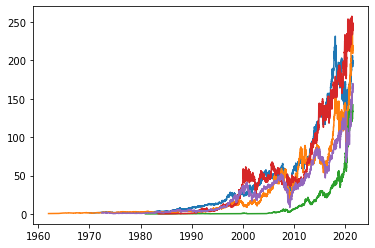

In [127]:
plt.plot(MMM)
plt.plot(CAT)
plt.plot(AAPL)
plt.plot(AMGN)
plt.plot(AXP)

In [134]:
MMM=MMM.tail(37)
AXP=AXP.tail(37)
AAPL=AAPL.tail(37)
AMGN=AMGN.tail(37)
CAT=CAT.tail(37)

In [136]:
stonks=[MMM,AXP,AAPL,AMGN,CAT]

In [129]:
train, test = temporal_train_test_split(MMM, test_size=30)
test_sq=test.squeeze()
train_sq=train.squeeze()
arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
       suppress_warnings=True, maxiter=100,seasonal=True, m=1)
y_pred = arima.predict(n_periods=test.shape[0])
y_true=test

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22.638, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.711, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.156, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20.878, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=96.187, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.159 seconds


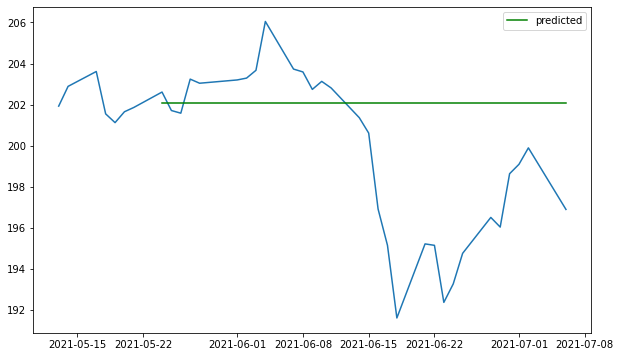

In [130]:
plt.figure(figsize=(10,6))
plt.plot(MMM)
plt.plot(test.index, y_pred, color='green', label = 'predicted')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113.322, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.054, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115.032, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.324, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=117.022, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds


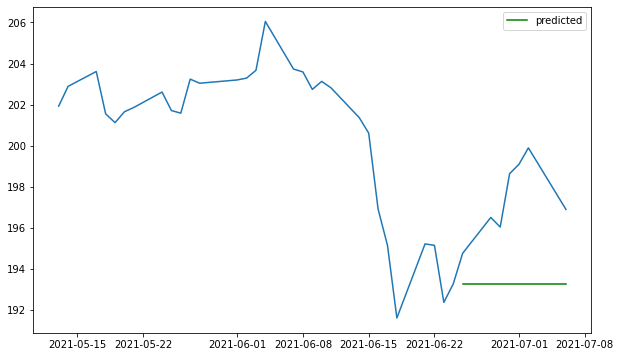

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=129.022, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=130.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=130.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128.551, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds


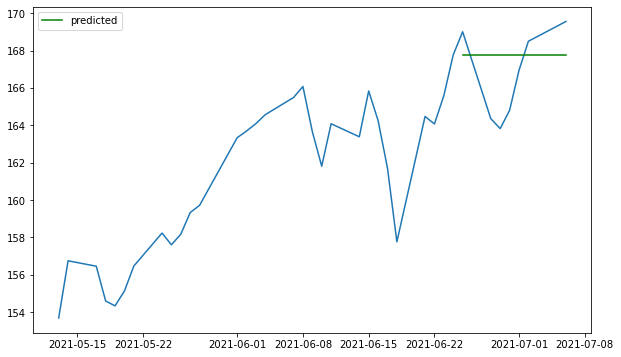

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=109.682, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104.935, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.266, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.046, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106.259, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=106.250, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=107.721, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=104.842, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.216 seconds


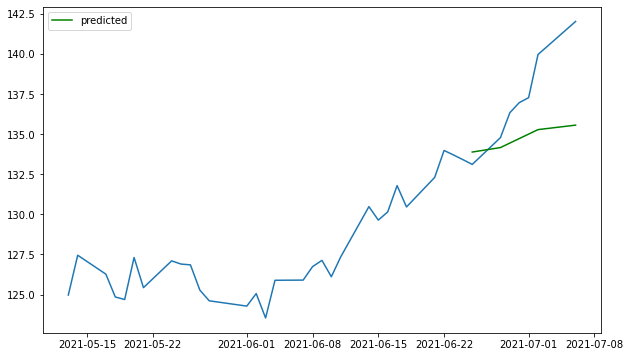

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.681, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=139.423, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139.448, Time=0.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=136.190, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=141.385, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.216 seconds


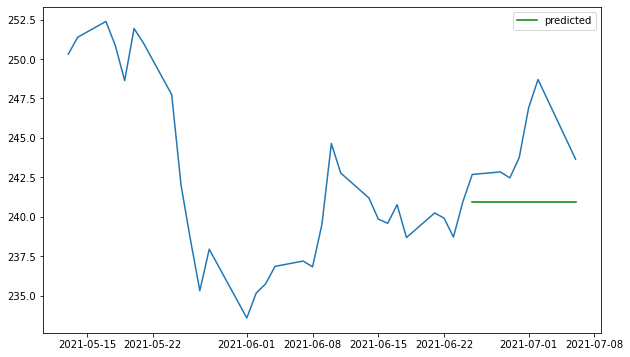

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.281, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=155.751, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.774, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=156.535, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=155.255, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=155.323, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=157.255, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=152.271, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=153.967, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=154.039, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=154.078, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=156.265, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.332 seconds


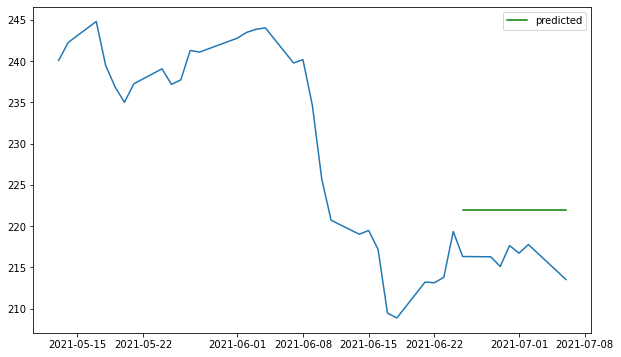

In [138]:
for each in stonks:    
    train, test = temporal_train_test_split(each, test_size=7)
    test_sq=test.squeeze()
    train_sq=train.squeeze()
    arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
           suppress_warnings=True, maxiter=100,seasonal=True, m=1)
    y_pred = arima.predict(n_periods=test.shape[0])
    y_true=test
    plt.figure(figsize=(10,6))
    plt.plot(each)
    plt.plot(test.index, y_pred, color='green', label = 'predicted')
    plt.legend()
    plt.show()

These results are all pretty terrible. In the next notebook, we'll try again with Prophet, Facebook's time forecasting library.